In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import statsmodels.api as sm

from numpy import asarray
from sklearn.preprocessing import MinMaxScaler

from dateutil.relativedelta import relativedelta

pd.set_option('display.max_row', 1000)
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

from IPython.display import HTML
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
#pd.reset_option('display.float_format')

In [95]:
data = pd.read_csv("./data/kc_house_data.csv")

# Misc Functions

In [96]:

def checkForColinearity(df_ColsToCheck):
    df=df_ColsToCheck.corr().abs().stack().reset_index().sort_values(0, ascending=False)

    #zip the variable name columns (Which were only named level_0 and level_1 by default) in a new column named "pairs"
    df['pairs'] = list(zip(df.level_0, df.level_1))

    #set index to pairs
    df.set_index(['pairs'], inplace = True)

    #drop level columns
    df.drop(columns=['level_1', 'level_0'], inplace = True)

    #rename correlation column as cc rather than 0
    df.columns = ['cc']

    #drop duplicates. This could be dangerous if you have variables perfectly correlated with variables other than themselves.
    df.drop_duplicates(inplace=True)
    df = df[(df.cc>.70) & (df.cc <1)]
    return df

def correlation_heatmap(df):
    _,ax=plt.subplots(figsize=(60,30))
    colormap=sns.diverging_palette(220,10,as_cmap=True)
    sns.heatmap(df.corr(),annot=True,cmap=colormap)

def checkForVIF(df_ColsToCheck):
#     X = df[x_cols]
    vif = [variance_inflation_factor(df_ColsToCheck.values, i) for i in range(df_ColsToCheck.shape[1])]
    vifresults = list(zip(df_ColsToCheck.columns, vif))
    return vifresults

def scaleData_min_max (df_continuous):
    scaler = MinMaxScaler()
    # transform data
    scaler_a = MinMaxScaler().fit(df_continuous)
    scaler_ = scaler.fit_transform(df_continuous)
    scaled_df = pd.DataFrame(scaler_, columns=df_continuous.columns)
    scaled_df_no_index = scaled_df.reset_index(drop=True)
    #
    return scaled_df_no_index, scaler_a

# Preprocessing

Ensure No Missing Values

waterfront      2376
view              63
yr_renovated    3842
dtype: int64


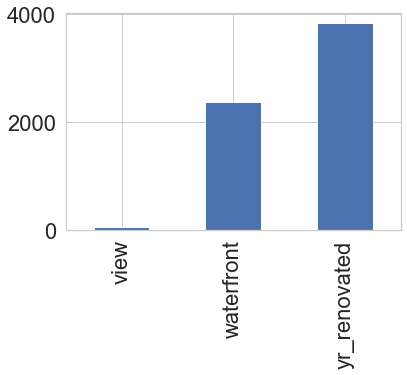

In [97]:
missing = data.isnull().sum()
missing = missing[missing > 0]
print (missing)
missing.sort_values(inplace=True)
missing.plot.bar();

In [98]:
listofBaseColumns = data.columns
listofBaseColumns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Dealing with Missing Values

In [99]:
#fill In Waterfront and View Nulls
data_No_NAs = data
data_No_NAs['waterfront'].fillna(data['waterfront'].mode()[0], inplace=True)
data_No_NAs['view'].fillna(data['view'].mode()[0], inplace=True)


#fill In Year Renovated and insert "Age of Home" (Today - Year Built) and "Years Since Renovated"
data_No_NAs["yr_renovated"].fillna(0, inplace=True)
# data_No_NAs["yr_renovated"]  = data_No_NAs.apply(lambda row : (row['yr_built']) if row["yr_renovated"] == 0 else row["yr_renovated"], axis=1)

#handle "?" in the sqrt basement column
data_No_NAs["sqft_basement"]  = data_No_NAs.apply(lambda row : 0 if row["sqft_basement"] == "?" else row["sqft_basement"], axis=1)
data_No_NAs["sqft_basement"] = data_No_NAs["sqft_basement"].astype('float')


### Add Potential Interesting Columns using basedata

In [100]:
data_No_NAs.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [101]:
data_No_NAs.sort_values(by="yr_renovated").head(15)

id        date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15
0      7129300520  10/13/2014   221900.0         3       1.00         1180      5650     1.0         0.0   0.0          3      7        1180            0.0      1955           0.0    98178  47.5112 -122.257           1340        5650
14297  5693500760    7/7/2014   570000.0         3       1.00         1890      3330     1.5         0.0   0.0          4      7        1390          500.0      1901           0.0    98103  47.6597 -122.352           1530        3330
14296  3787000120   1/22/2015   577000.0         3       2.25         2370      7878     2.0         0.0   0.0          3      8        2370            0.0      1985           0.0    98034  47.7281 -122.168           1870        7766
14295  3528000040   3/26/2015  1800000.0         3       3.25         5290    224442     2.0         0.0   0.0          4     11        4540          750.0      1988           0.0    98053  47.6671 -122.051           3750       84936
14294  3528000040   10/1/2014  1690000.0         3       3.25         5290    224442     2.0         0.0   0.0          4     11        4540          750.0      1988           0.0    98053  47.6671 -122.051           3750       84936
14293  2887701251   10/7/2014   392800.0         2       1.00          740      4275     1.0         0.0   0.0          5      6         740            0.0      1924           0.0    98115  47.6880 -122.308           1900        4275
14292  1689400150    2/6/2015   848000.0         3       2.75         2170      2738     1.5         0.0   0.0          4      9        1550          620.0      1930           0.0    98109  47.6389 -122.349           1170        1062
14291  2872100385   3/18/2015   460000.0         2       2.00         1080      5000     1.0         0.0   0.0          5      6        1080            0.0      1923           0.0    98117  47.6826 -122.394           1530        5000
14298  8892900180   6/17/2014   250000.0         3       1.75         1160      6134     1.0         0.0   0.0          3      7        1160            0.0      1998           0.0    98002  47.3414 -122.218           1330        6301
14290  3793501400   8/20/2014   397000.0         4       2.50         3000      8584     2.0         0.0   0.0          3      7        3000            0.0      2003           0.0    98038  47.3690 -122.032           2610        7570
14288  7303100210   5/27/2014   355000.0         4       2.25         1810      4970     2.0         0.0   0.0          3      7        1810            0.0      2003           0.0    98059  47.5003 -122.156           1810        4858
14287  8732000410   1/14/2015   272000.0         3       1.50         1760      9600     1.0         0.0   0.0          4      7        1760            0.0      1966           0.0    98031  47.4085 -122.195           1450        9600
14286  1446800995    8/5/2014   300000.0         3       2.50         2020      6628     1.0         0.0   0.0          4      7        1250          770.0      1963           0.0    98168  47.4934 -122.332           1540        9995
14285   923000120    4/8/2015   515000.0         3       1.50         2200      7620     1.0         0.0   0.0          4      7        1130         1070.0      1942           0.0    98177  47.7263 -122.363           2170        7672
14284  7237500360   11/6/2014  1500000.0         4       4.25         5550     12968     2.0         0.0   0.0          3     11        5550            0.0      2005           0.0    98059  47.5305 -122.135           4750       13001

In [102]:
#Any relationship if renovated
data_No_NAs["If_renovated"]  = data_No_NAs.apply(lambda row : 1 if row["yr_renovated"] > 0 else 0, axis=1)


# Any relatinship with age of home
data_No_NAs["AgeOfHome"] = (2020 - data_No_NAs["yr_built"])

# Is there any relationship with zipcode
data_No_NAs["zipcode_str"] = data_No_NAs["zipcode"].astype('str')
data_No_NAs['ZipFirst3'] = data_No_NAs["zipcode_str"].str[:3]
data_No_NAs['ZipFirst3_int'] = data_No_NAs["ZipFirst3"].astype('int')
data_No_NAs = data_No_NAs.drop("zipcode_str", axis=1) 

# Is there any relationship with the month of sale?
data_No_NAs['salesyear'] = pd.DatetimeIndex(data_No_NAs['date']).year
data_No_NAs['sls_month'] = pd.DatetimeIndex(data_No_NAs['date']).month
                                                 
                                                 
# Create new variables Rooms and sqft_Above_Combo given high vifs
data_No_NAs["ttl_rooms"] = data_No_NAs['bedrooms']*data_No_NAs['bathrooms']

In [103]:
data_No_NAs.head(15)

id        date      price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  If_renovated  AgeOfHome ZipFirst3  ZipFirst3_int  salesyear  sls_month  ttl_rooms
0   7129300520  10/13/2014   221900.0         3       1.00         1180      5650     1.0         0.0   0.0          3      7        1180            0.0      1955           0.0    98178  47.5112 -122.257           1340        5650             0         65       981            981       2014         10       3.00
1   6414100192   12/9/2014   538000.0         3       2.25         2570      7242     2.0         0.0   0.0          3      7        2170          400.0      1951        1991.0    98125  47.7210 -122.319           1690        7639             1         69       981            981       2014         12       6.75
2   5631500400   2/25/2015   180000.0         2       1.00          770     10000     1.0         0.0   0.0          3      6         770            0.0      1933           0.0    98028  47.7379 -122.233           2720        8062             0         87       980            980       2015          2       2.00
3   2487200875   12/9/2014   604000.0         4       3.00         1960      5000     1.0         0.0   0.0          5      7        1050          910.0      1965           0.0    98136  47.5208 -122.393           1360        5000             0         55       981            981       2014         12      12.00
4   1954400510   2/18/2015   510000.0         3       2.00         1680      8080     1.0         0.0   0.0          3      8        1680            0.0      1987           0.0    98074  47.6168 -122.045           1800        7503             0         33       980            980       2015          2       6.00
5   7237550310   5/12/2014  1230000.0         4       4.50         5420    101930     1.0         0.0   0.0          3     11        3890         1530.0      2001           0.0    98053  47.6561 -122.005           4760      101930             0         19       980            980       2014          5      18.00
6   1321400060   6/27/2014   257500.0         3       2.25         1715      6819     2.0         0.0   0.0          3      7        1715            0.0      1995           0.0    98003  47.3097 -122.327           2238        6819             0         25       980            980       2014          6       6.75
7   2008000270   1/15/2015   291850.0         3       1.50         1060      9711     1.0         0.0   0.0          3      7        1060            0.0      1963           0.0    98198  47.4095 -122.315           1650        9711             0         57       981            981       2015          1       4.50
8   2414600126   4/15/2015   229500.0         3       1.00         1780      7470     1.0         0.0   0.0          3      7        1050          730.0      1960           0.0    98146  47.5123 -122.337           1780        8113             0         60       981            981       2015          4       3.00
9   3793500160   3/12/2015   323000.0         3       2.50         1890      6560     2.0         0.0   0.0          3      7        1890            0.0      2003           0.0    98038  47.3684 -122.031           2390        7570             0         17       980            980       2015          3       7.50
10  1736800520    4/3/2015   662500.0         3       2.50         3560      9796     1.0         0.0   0.0          3      8        1860         1700.0      1965           0.0    98007  47.6007 -122.145           2210        8925             0         55       980            980       2015          4       7.50
11  9212900260   5/27/2014   468000.0         2       1.00         1160      6000     1.0         0.0   0.0          4      7         860          300.0      1942           0.0    98115  47.6900 -122.292           1330        6000             0

In [104]:
df_check2 = data_No_NAs.loc[data_No_NAs.waterfront ==1]
len(df_check2)

146

In [105]:
data_No_NAs.head()

id        date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  If_renovated  AgeOfHome ZipFirst3  ZipFirst3_int  salesyear  sls_month  ttl_rooms
0  7129300520  10/13/2014  221900.0         3       1.00         1180      5650     1.0         0.0   0.0          3      7        1180            0.0      1955           0.0    98178  47.5112 -122.257           1340        5650             0         65       981            981       2014         10       3.00
1  6414100192   12/9/2014  538000.0         3       2.25         2570      7242     2.0         0.0   0.0          3      7        2170          400.0      1951        1991.0    98125  47.7210 -122.319           1690        7639             1         69       981            981       2014         12       6.75
2  5631500400   2/25/2015  180000.0         2       1.00          770     10000     1.0         0.0   0.0          3      6         770            0.0      1933           0.0    98028  47.7379 -122.233           2720        8062             0         87       980            980       2015          2       2.00
3  2487200875   12/9/2014  604000.0         4       3.00         1960      5000     1.0         0.0   0.0          5      7        1050          910.0      1965           0.0    98136  47.5208 -122.393           1360        5000             0         55       981            981       2014         12      12.00
4  1954400510   2/18/2015  510000.0         3       2.00         1680      8080     1.0         0.0   0.0          3      8        1680            0.0      1987           0.0    98074  47.6168 -122.045           1800        7503             0         33       980            980       2015          2       6.00

In [106]:
missing = data_No_NAs.isnull().sum()
missing

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
If_renovated     0
AgeOfHome        0
ZipFirst3        0
ZipFirst3_int    0
salesyear        0
sls_month        0
ttl_rooms        0
dtype: int64

# <u> <font color='red'>Model 1 Dataset</font></u>

##    Creating Inital Dataset

### Looking for Linear Relationships, Drop Features With Low Relationship, Scale

### Transform target and remove outliers to improve linearity

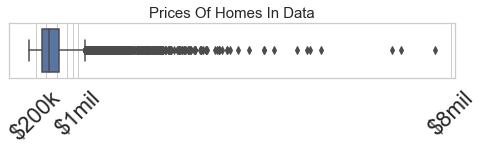

In [107]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Prices Of Homes In Data', fontsize=15)
sns.boxplot(x=data_No_NAs['price'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
           labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
plt.show();

In [108]:
q_high = data_No_NAs['price'].quantile(.75)
q_low = data_No_NAs['price'].quantile(.25)
print(f' Lower Range - ${q_low} , Upper Range - ${q_high}')

 Lower Range - $322000.0 , Upper Range - $645000.0


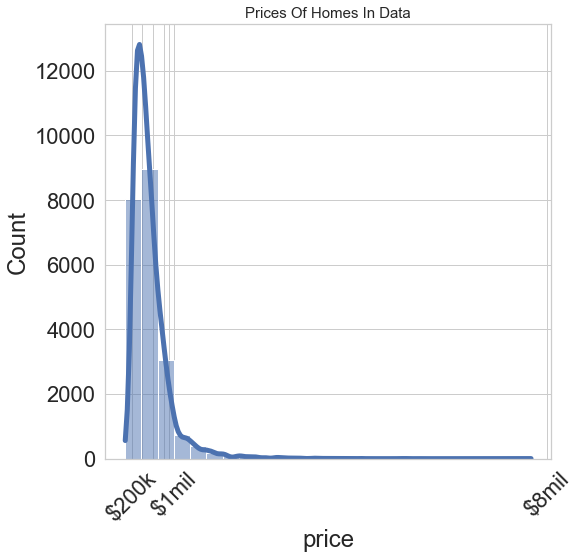

In [109]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
plt.title('Prices Of Homes In Data', fontsize=15)
sns.histplot(x= "price",
             data=data_No_NAs,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
           labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

Given Heavy skew right, going to log transform and then drop outliers prices based on log transformation

In [110]:
data_No_NAs["log_price"] = np.log(data_No_NAs['price'])

<ipython-input-111-2db5c8e7d4c8>:27: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


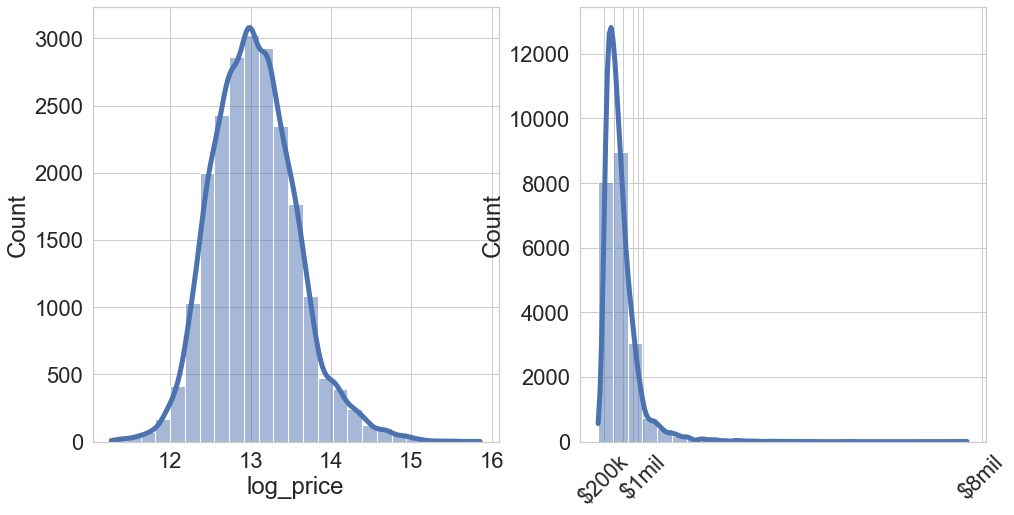

In [111]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

# fig = plt.figure(figsize = (8,8))

sns.histplot(data_No_NAs['log_price'], ax=ax, bins=25,
             kde=True,
             line_kws={"linewidth":5})

plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
                 labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'), rotation=45)
plt.xlabel('', fontsize=15)

# plt.set(ax.get_xticklabels(), rotation=45)
# ax.set_xlabel('')

sns.histplot(data_No_NAs['price'], ax=ax2, bins=25,
             kde=True,
             line_kws={"linewidth":5})

plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
                 labels= ('$200k', '', '', '',
                    '', '$1mil', '$8mil'), rotation=45)
plt.xlabel('', fontsize=15)
fig.show()

Target feature now looks more normalized, now drop outlines

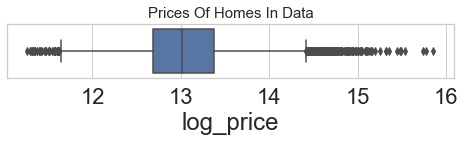

In [112]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Prices Of Homes In Data', fontsize=15)
sns.boxplot(x=data_No_NAs['log_price'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
# plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000, 8000000), 
#            labels= ('$200k', '', '', '',
#                     '', '$1mil', '$8mil'))
# # plt.xlabel('Price Of Home', fontsize=15)
# plt.setp(ax.get_xticklabels(), rotation=45)
# ax.set_xlabel('')
plt.show();

In [113]:
# lower = 250000
# upper = 800000
# 12.409013489526863
# 13.695600261291716
# 244999.99999999983
# 886999.9999999995
q_low = data_No_NAs['log_price'].quantile(0.1)
q_high = data_No_NAs['log_price'].quantile(0.9)

# print(Q1)
# print(Q3)
# np.exp(q_high)
# print(np.exp(Q1))
# print(np.exp(Q3))

data_Target_Homes = data_No_NAs[data_No_NAs['log_price']<q_high]
data_Target_Homes = data_Target_Homes[data_Target_Homes['log_price']>q_low]

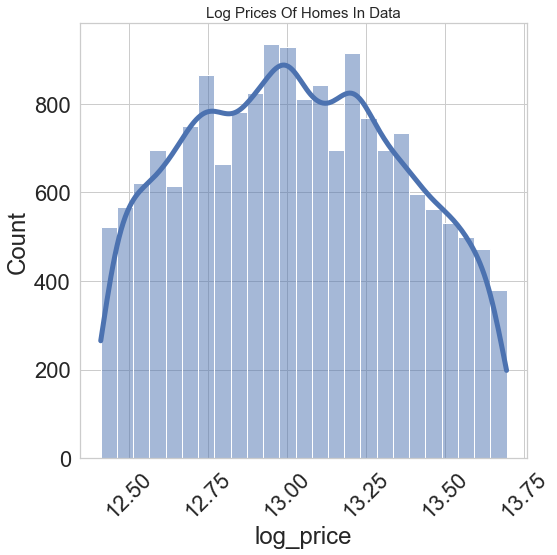

In [114]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
plt.title('Log Prices Of Homes In Data', fontsize=15)
sns.histplot(x= "log_price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
# plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000), 
#            labels= ('$200k', '', '', '',
#                     '', '$1mil'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

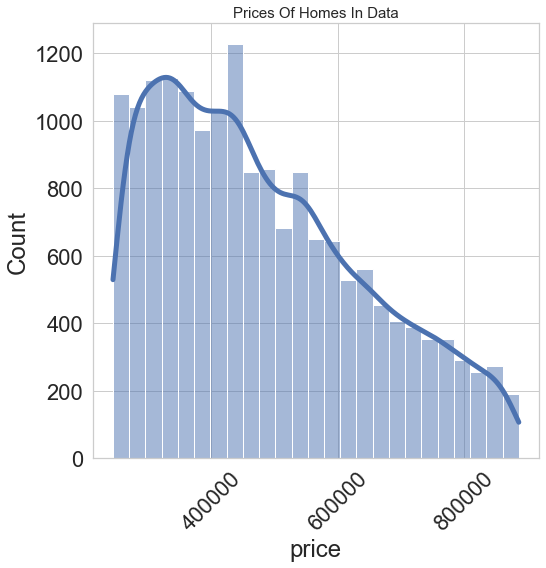

In [115]:
sns.set_style('whitegrid')
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
plt.title('Prices Of Homes In Data', fontsize=15)
sns.histplot(x= "price",
             data=data_Target_Homes,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
# plt.xticks(ticks=(200000, 400000, 600000, 800000, 900000, 1000000), 
#            labels= ('$200k', '', '', '',
#                     '', '$1mil'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()

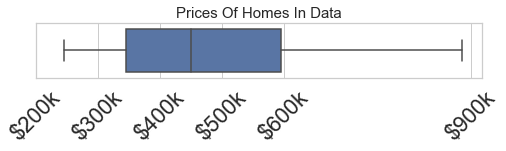

In [116]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Prices Of Homes In Data', fontsize=15)
sns.boxplot(x=data_Target_Homes['price'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
plt.xticks(ticks=(200000, 300000, 400000, 500000,600000, 900000), 
           labels= ('$200k','$300k', '$400k', '$500k','$600k','$900k'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
plt.show();

In [117]:
data_Target_Homes.shape

(17272, 29)

Examin features for outliers

In [118]:
data_Target_Homes.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'If_renovated',
       'AgeOfHome', 'ZipFirst3', 'ZipFirst3_int', 'salesyear', 'sls_month',
       'ttl_rooms', 'log_price'],
      dtype='object')

In [119]:
ColsToCheckForOutliers = data_Target_Homes[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors','sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15',
       'AgeOfHome','ttl_rooms']]

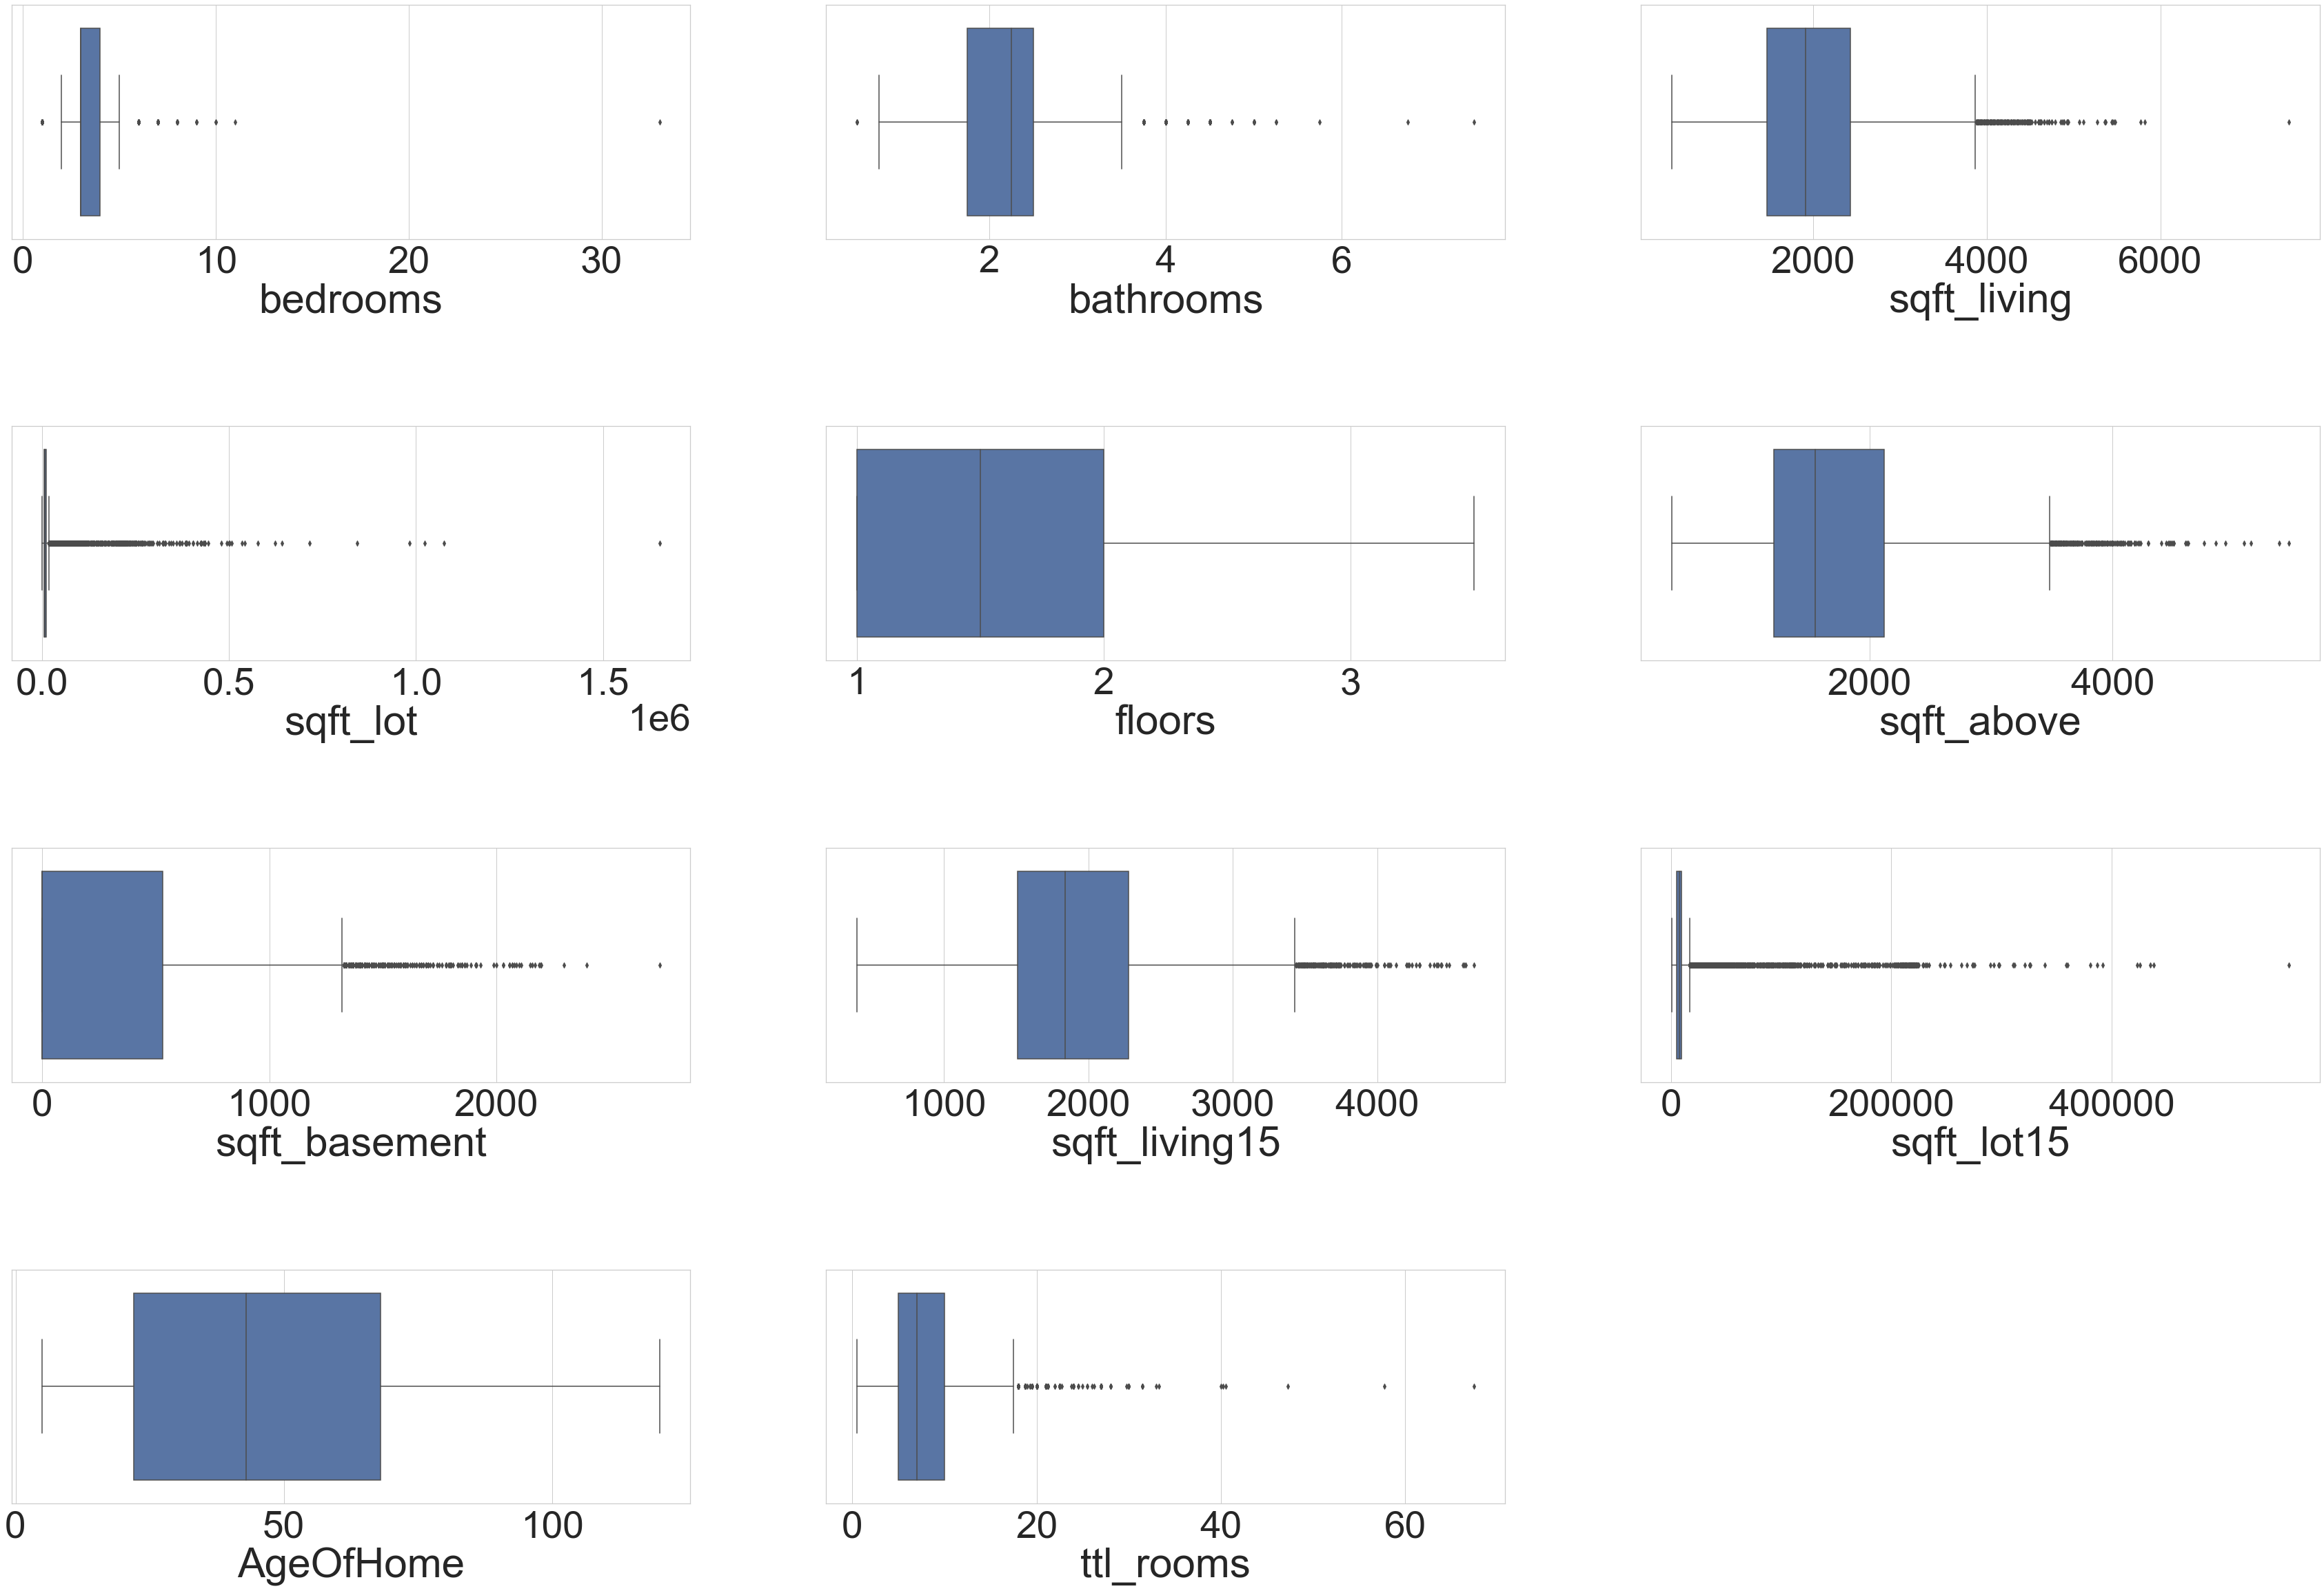

In [120]:
plt.figure(figsize=(60,40), facecolor="white")
plt.subplots_adjust(hspace = 0.8)
sns.set_style('whitegrid')
sns.set(font_scale=5)
sns.set_style("whitegrid")
for index, column in enumerate(ColsToCheckForOutliers):

    if column != "price":
        ax = plt.subplot(4, 3, index+1)
#         sns.boxplot(x=data_Target_Homes['grade'],y=data_Target_Homes['price'],ax=ax[0])
        sns.boxplot(x=column, data=ColsToCheckForOutliers, ax=ax);
         
plt.show();


Remove additional outliers Ex. bedrooms = 33 , Bathrooms < 8, Sqft_Lot <12000. > 4000, Homes that have sold more than 1 on target years

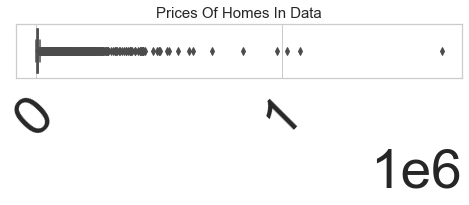

In [121]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Prices Of Homes In Data', fontsize=15)
sns.boxplot(x=data_Target_Homes['sqft_lot'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
# plt.xticks(ticks=(200000, 300000, 400000, 500000,600000, 900000), 
#            labels= ('$200k','$300k', '$400k', '$500k','$600k','$900k'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
plt.show();

In [122]:
#Keep homes that have bewteen 1-6 bathrooms
data_Target_Homes = data_Target_Homes.loc[(1<= data_Target_Homes['bathrooms']) & (data_Target_Homes['bathrooms'] <= 6)]  # > 6 Bathrooms

#Keep homes between 1 - 10 bedrooms < 10
data_Target_Homes = data_Target_Homes.loc[(1<= data_Target_Homes['bedrooms']) & (data_Target_Homes['bedrooms'] <= 10)]  # > 6 Bathrooms

#Keep lots between 4000 and 12000 ft
data_Target_Homes = data_Target_Homes.loc[(4000 <= data_Target_Homes['sqft_lot']) & (data_Target_Homes['sqft_lot'] <= 11000)] #4000, 12000


# data_Target_Homes = data_Target_Homes.loc[data_Target_Homes['AgeOfHome'] < 50]

# Keep homes with finished basements or are waterfront
data_Target_Homes = data_Target_Homes.loc[(data_Target_Homes['sqft_basement'] >100) | (data_Target_Homes['waterfront']==1)]

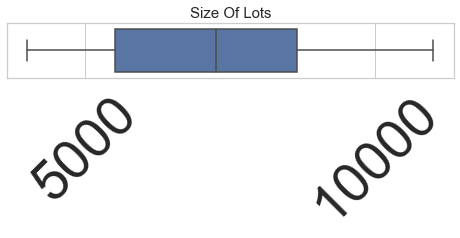

In [123]:
sns.set_style('whitegrid')
fig,ax=plt.subplots(1,1,figsize=(8,1))
plt.title('Size Of Lots', fontsize=15)
sns.boxplot(x=data_Target_Homes['sqft_lot'], labels=None)
# sns.boxplot(x=data_No_NAs['price'],ax=ax[1])
# _ , axes = plt.subplots(1, 1, figsize=(15,10))
# sns.boxplot(x=data['bathrooms'],y=data['price'])
# plt.xticks(ticks=(200000, 300000, 400000, 500000,600000, 900000), 
#            labels= ('$200k','$300k', '$400k', '$500k','$600k','$900k'))
# plt.xlabel('Price Of Home', fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('')
plt.show();

In [124]:
#Remove Homes That have sold More Than Twice In the Same year (Flipper Homes)
df_housesThatSoldTwice = data_Target_Homes.groupby('id').count().reset_index().sort_values(by="date", ascending=False)
df_housesThatSoldTwice = df_housesThatSoldTwice[df_housesThatSoldTwice["date"] > 1]
data_Target_Homes = data_Target_Homes.merge(df_housesThatSoldTwice[['id','date']], on="id", how='left')
data_Target_Homes.date_y.fillna(0, inplace=True)
data_Target_Homes = data_Target_Homes[data_Target_Homes["date_y"]==0]
data_Target_Homes = data_Target_Homes.drop(['date_y'], axis=1)
data_Target_Homes.rename(columns={"date_x":"date"}, inplace=True)

In [125]:
data_Target_Homes.describe()

id          price     bedrooms    bathrooms  sqft_living      sqft_lot       floors   waterfront         view    condition        grade   sqft_above  sqft_basement     yr_built  yr_renovated       zipcode          lat         long  sqft_living15    sqft_lot15  If_renovated    AgeOfHome  ZipFirst3_int    salesyear    sls_month    ttl_rooms    log_price
count  3.999000e+03    3999.000000  3999.000000  3999.000000  3999.000000   3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000    3999.000000  3999.000000   3999.000000   3999.000000  3999.000000  3999.000000    3999.000000   3999.000000   3999.000000  3999.000000    3999.000000  3999.000000  3999.000000  3999.000000  3999.000000
mean   4.741245e+09  498918.235309     3.558890     2.085771  2104.790948   7208.189547     1.160290     0.001250     0.246562     3.576644     7.366342  1384.251313     720.539635  1959.734684     66.411603  98093.476369    47.589936  -122.267913    1863.511378   7251.098525      0.033258    60.265316     980.593398  2014.317079     6.634909     7.702488    13.063824
std    2.857228e+09  165866.184106     0.901042     0.650947   598.929791   1894.904357     0.341682     0.035342     0.724904     0.699149     0.729619   447.525294     320.145574    24.494762    358.113401     55.705452     0.123680     0.106518     461.601281   2241.389194      0.179333    24.494762       0.491261     0.465397     3.110720     3.810426     0.339230
min    3.600072e+06  245700.000000     1.000000     1.000000   680.000000   4000.000000     1.000000     0.000000     0.000000     2.000000     5.000000   480.000000       0.000000  1900.000000      0.000000  98001.000000    47.193700  -122.475000     460.000000    980.000000      0.000000     5.000000     980.000000  2014.000000     1.000000     1.000000    12.411867
25%    2.324539e+09  360000.000000     3.000000     1.750000  1700.000000   5530.500000     1.000000     0.000000     0.000000     3.000000     7.000000  1090.000000     480.000000  1945.000000      0.000000  98034.000000    47.518950  -122.354000    1550.000000   5500.000000      0.000000    43.000000     980.000000  2014.000000     4.000000     5.250000    12.793859
50%    4.058800e+09  475000.000000     3.000000     2.000000  2030.000000   7254.000000     1.000000     0.000000     0.000000     3.000000     7.000000  1290.000000     700.000000  1961.000000      0.000000  98108.000000    47.594300  -122.292000    1820.000000   7359.000000      0.000000    59.000000     981.000000  2014.000000     6.000000     7.000000    13.071070
75%    7.445750e+09  618750.000000     4.000000     2.500000  2405.000000   8652.500000     1.000000     0.000000     0.000000     4.000000     8.000000  1550.000000     930.000000  1977.000000      0.000000  98126.000000    47.692500  -122.191000    2090.000000   8602.000000      0.000000    75.000000     981.000000  2015.000000     9.000000    10.000000    13.335456
max    9.900000e+09  886000.000000     9.000000     5.000000  5110.000000  11000.000000     3.000000     1.000000     4.000000     5.000000    11.000000  3860.000000    2170.000000  2015.000000   2015.000000  98199.000000    47.777600  -121.417000    4495.000000  29279.000000      1.000000   120.000000     981.000000  2015.000000    12.000000    40.500000    13.694472

###Review Linearity

In [126]:
CheckForlinearity = data_Target_Homes.drop(columns=['id','date','long', 'ZipFirst3', 'log_price'])

In [127]:
CheckForlinearity.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode      lat  sqft_living15  sqft_lot15  If_renovated  AgeOfHome  ZipFirst3_int  salesyear  sls_month  ttl_rooms
0  538000.0         3       2.25         2570      7242     2.0         0.0   0.0          3      7        2170          400.0      1951        1991.0    98125  47.7210           1690        7639             1         69            981       2014         12       6.75
1  604000.0         4       3.00         1960      5000     1.0         0.0   0.0          5      7        1050          910.0      1965           0.0    98136  47.5208           1360        5000             0         55            981       2014         12      12.00
2  662500.0         3       2.50         3560      9796     1.0         0.0   0.0          3      8        1860         1700.0      1965           0.0    98007  47.6007           2210        8925             0         55            980       2015          4       7.50
3  468000.0         2       1.00         1160      6000     1.0         0.0   0.0          4      7         860          300.0      1942           0.0    98115  47.6900           1330        6000             0         78            981       2014          5       2.00
4  650000.0         4       3.00         2950      5000     2.0         0.0   3.0          3      9        1980          970.0      1979           0.0    98126  47.5714           2140        4000             0         41            981       2015          1      12.00

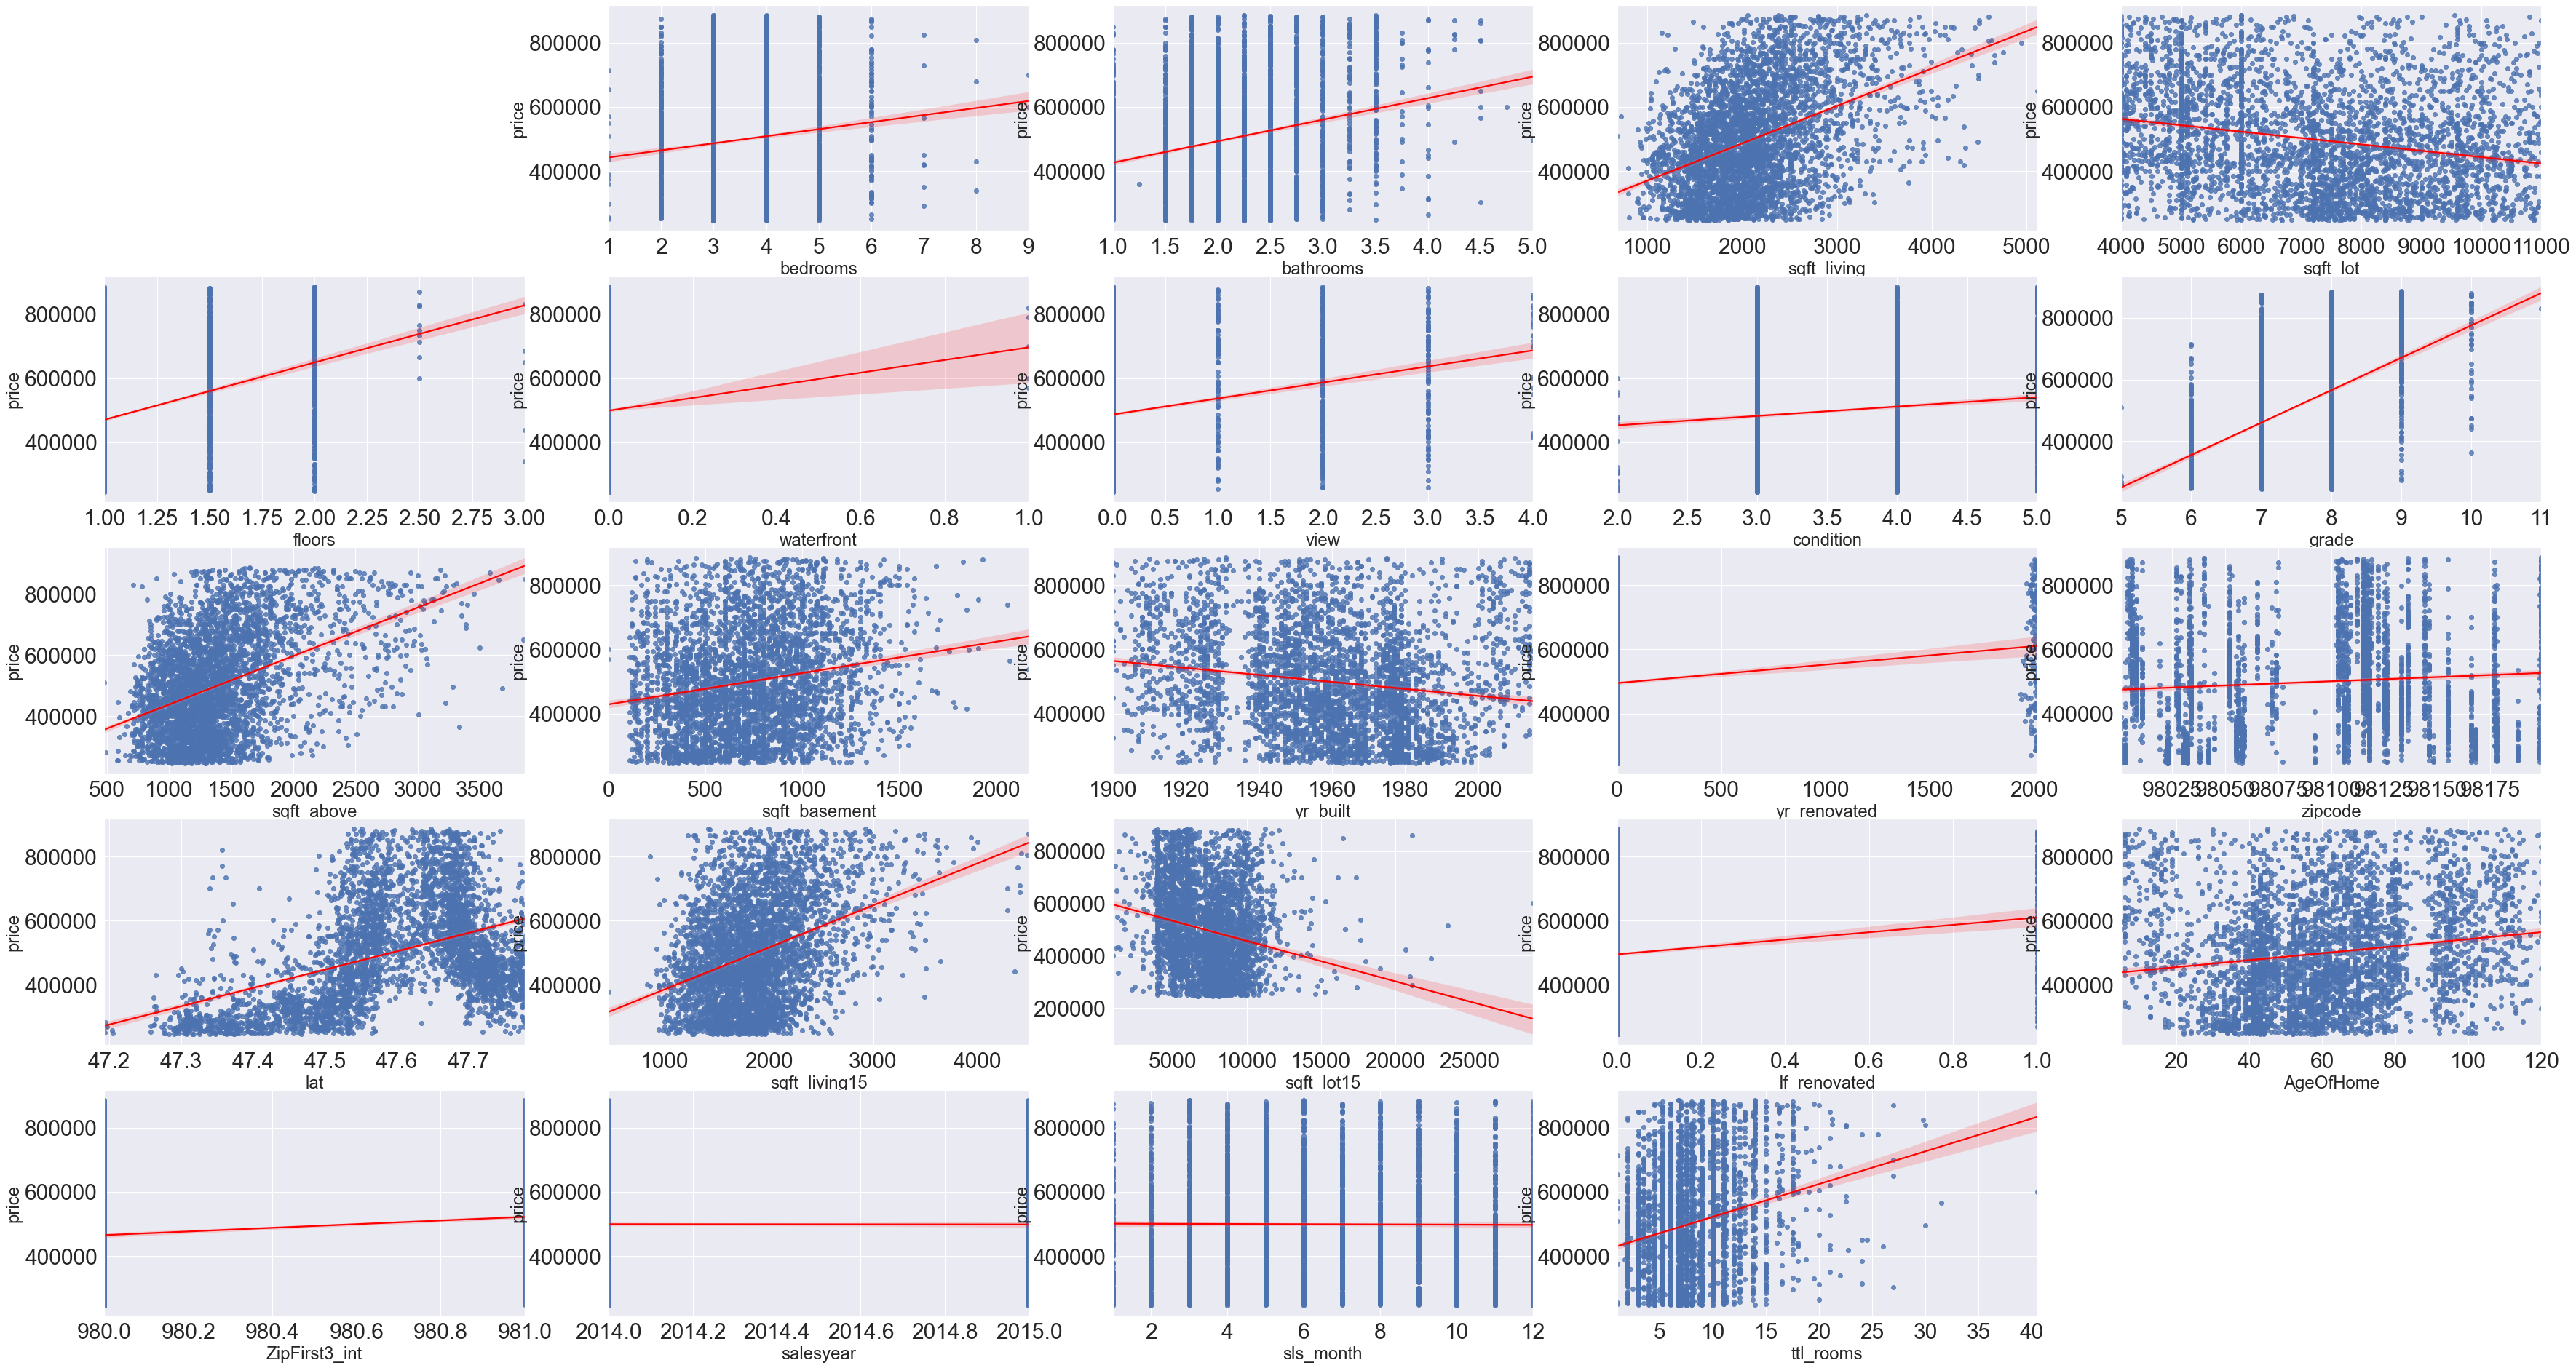

In [128]:
plt.figure(figsize=(60,40), facecolor="white")
sns.set(font_scale=2)

for index, column in enumerate(CheckForlinearity):

    if column != "price":
        ax = plt.subplot(6, 5, index+1)
        sns.regplot(x=column, y="price", data=CheckForlinearity, ax=ax, label='medium', line_kws={"color": "red"});
        plt.ticklabel_format(style='plain', axis='both')
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
    
plt.show();

Get a closer look at a few of the future categoricals

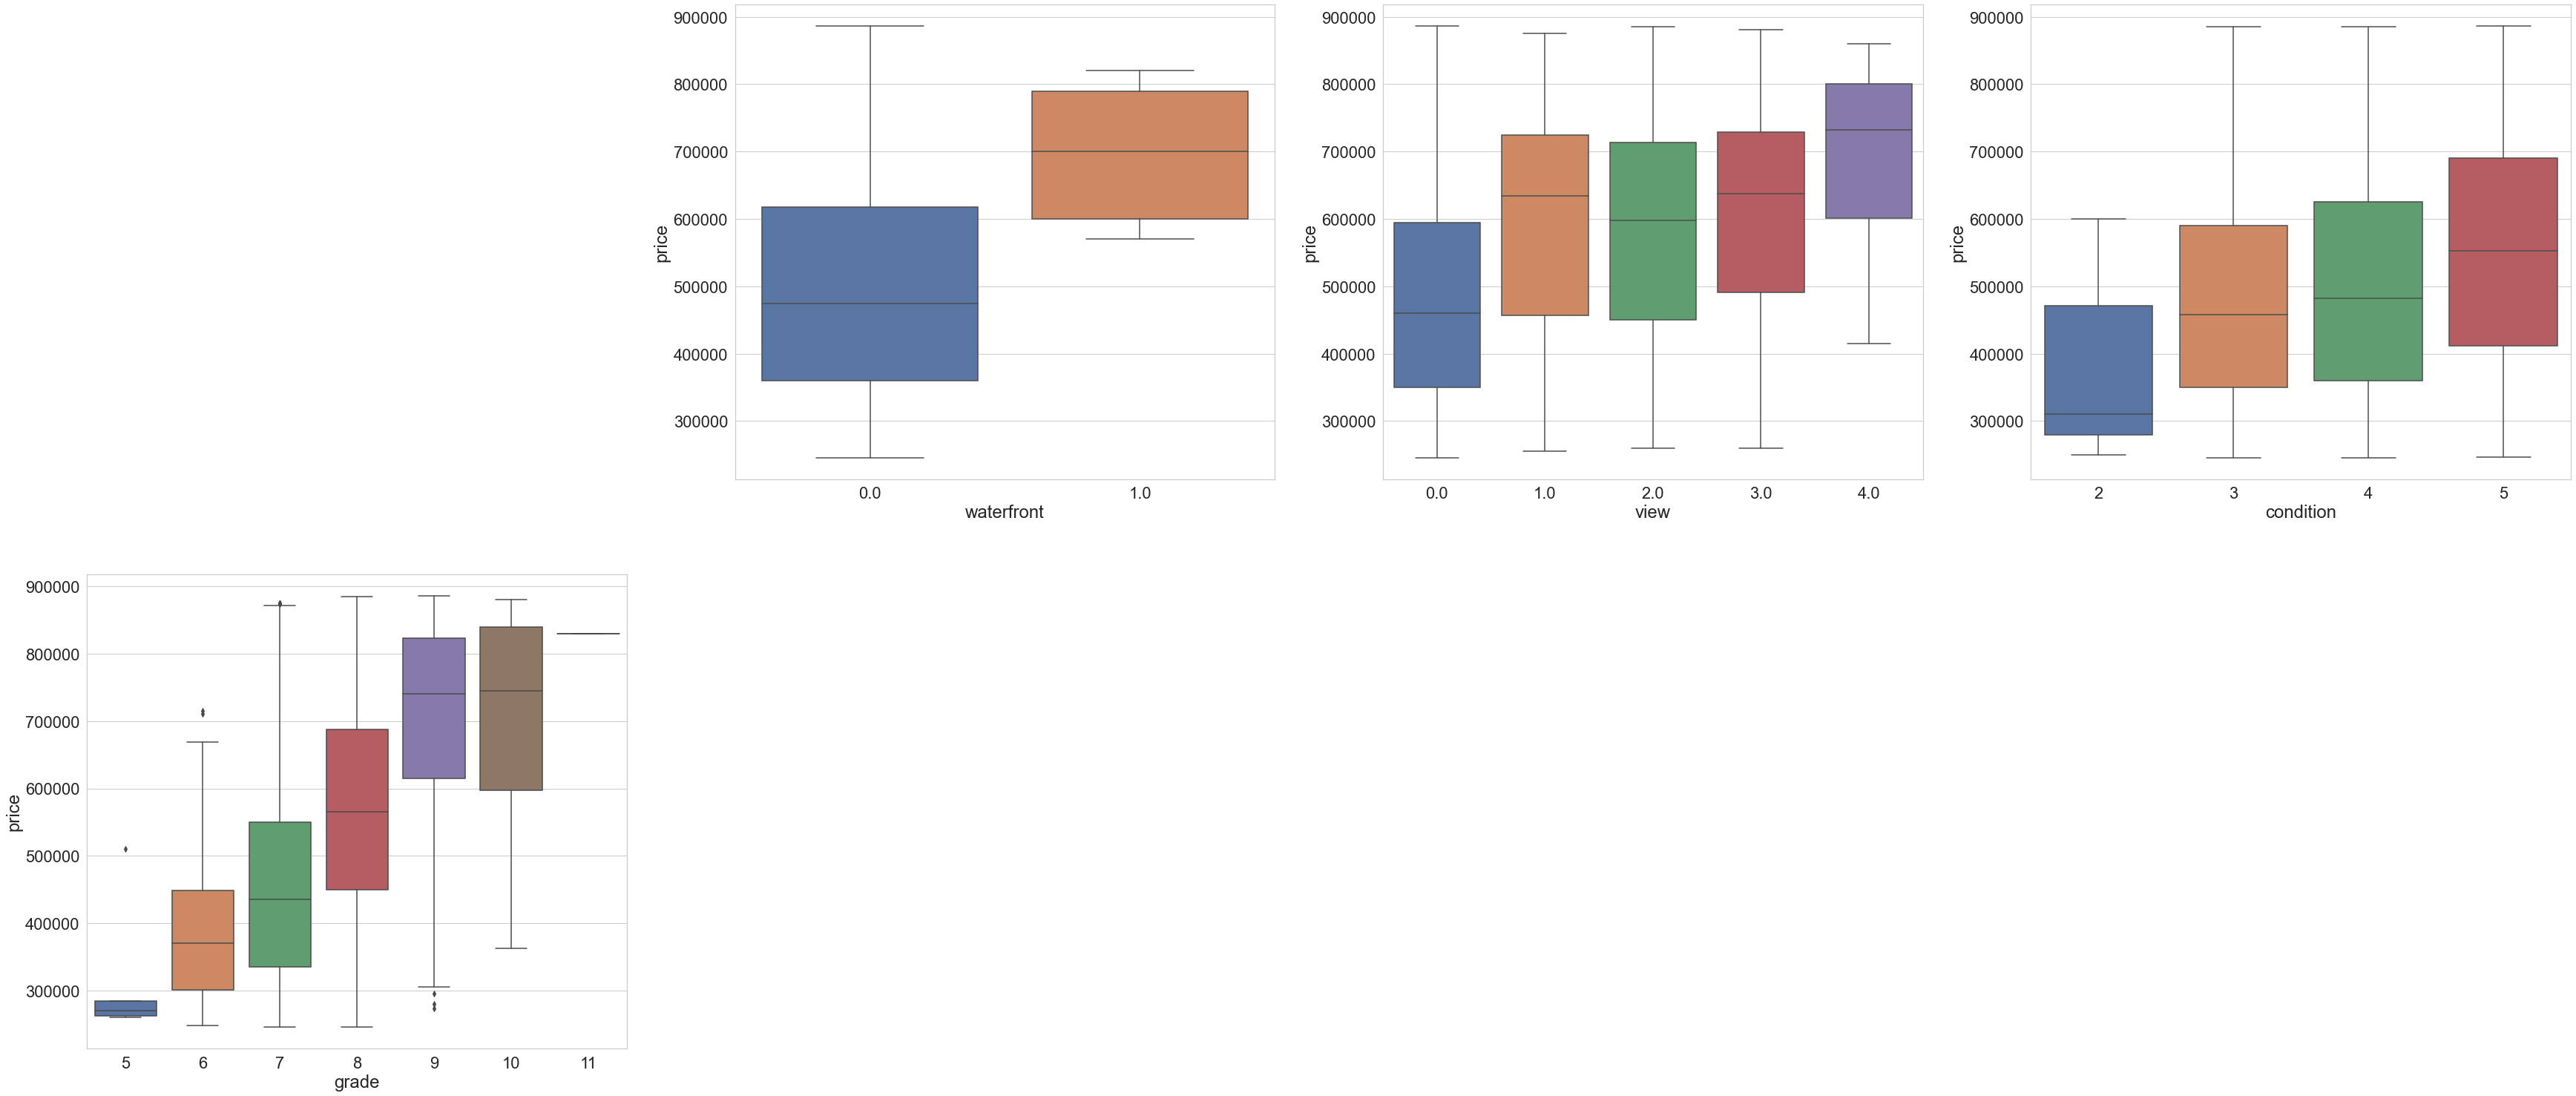

In [129]:

CategoricalsToCheck  = ['price','waterfront', 'view', 'condition', 'grade']


CheckForlinearity1 = CheckForlinearity[CategoricalsToCheck]

plt.figure(figsize=(60,40), facecolor="white")
sns.set(font_scale=2)
sns.set_style("whitegrid")
for index, column in enumerate(CheckForlinearity1):

    if column != "price":
        ax = plt.subplot(3, 4, index+1)
#         sns.boxplot(x=data_Target_Homes['grade'],y=data_Target_Homes['price'],ax=ax[0])
        sns.boxplot(x=column, y="price", data=CheckForlinearity1, ax=ax);
    
plt.show();


Above Confirming linear relationship with categoricals

In [130]:
pd.options.display.float_format = '{:,.0f}'.format
data_Target_Homes.describe()

id   price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat  long  sqft_living15  sqft_lot15  If_renovated  AgeOfHome  ZipFirst3_int  salesyear  sls_month  ttl_rooms  log_price
count         3,999   3,999     3,999      3,999        3,999     3,999   3,999       3,999 3,999      3,999  3,999       3,999          3,999     3,999         3,999    3,999 3,999 3,999          3,999       3,999         3,999      3,999          3,999      3,999      3,999      3,999      3,999
mean  4,741,244,565 498,918         4          2        2,105     7,208       1           0     0          4      7       1,384            721     1,960            66   98,093    48  -122          1,864       7,251             0         60            981      2,014          7          8         13
std   2,857,228,206 165,866         1          1          599     1,895       0           0     1          1      1         448            320        24           358       56     0     0            462       2,241             0         24              0          0          3          4          0
min       3,600,072 245,700         1          1          680     4,000       1           0     0          2      5         480              0     1,900             0   98,001    47  -122            460         980             0          5            980      2,014          1          1         12
25%   2,324,539,104 360,000         3          2        1,700     5,530       1           0     0          3      7       1,090            480     1,945             0   98,034    48  -122          1,550       5,500             0         43            980      2,014          4          5         13
50%   4,058,800,215 475,000         3          2        2,030     7,254       1           0     0          3      7       1,290            700     1,961             0   98,108    48  -122          1,820       7,359             0         59            981      2,014          6          7         13
75%   7,445,750,062 618,750         4          2        2,405     8,652       1           0     0          4      8       1,550            930     1,977             0   98,126    48  -122          2,090       8,602             0         75            981      2,015          9         10         13
max   9,900,000,190 886,000         9          5        5,110    11,000       3           1     4          5     11       3,860          2,170     2,015         2,015   98,199    48  -121          4,495      29,279             1        120            981      2,015         12         40         14

50% Data Points Between $800,000 - and $250,000, Remove Outliers on both sides and rerun, currently mean and standard deviation impacted significantly by large home values

In [131]:
# df_check2 = data_Target_Homes.loc[data_Target_Homes.waterfront ==1]
# df_check2

##    B. Scaling, Converting & Eliminating Multicolinearity

In [132]:
data_Target_Homes.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'If_renovated',
       'AgeOfHome', 'ZipFirst3', 'ZipFirst3_int', 'salesyear', 'sls_month',
       'ttl_rooms', 'log_price'],
      dtype='object')

In [133]:
# #Exclude metadatacolumns from colinearity check as they will not feed into regression model directely
# ColsToDrop = ["id","date", "log_price", "zipcode", "long", "lat", "ZipFirst3", "ZipFirst3_int","yr_built","price"]
# CheckForlinearity2 = data_No_NAs.drop(columns=ColsToDrop)

model1_Continuous_variables  = ['bedrooms', 'bathrooms','sqft_living','sqft_lot',
                                'sqft_basement','sqft_living15', 'sqft_lot15', 'floors',
                                'sqft_above','AgeOfHome','ttl_rooms']

data_Target_Homes_Continuous = data_Target_Homes[model1_Continuous_variables]
# model1_Continuous_variables = data_Target_Homes_Continuous.columns

In [134]:
#Scale Continuous initial data
scaled_df_no_index, scaler_1 = scaleData_min_max (data_Target_Homes_Continuous)

In [135]:
# pd.reset_option('display.float_format')
# scaled_df_no_index.head()

In [136]:
# # df = pd.DataFrame([[1,1.23,'Hello']], columns=list('ABC'))
# df2 = pd.DataFrame([[4000]],columns=['sqft_lot'])
# type(df2)

In [137]:
# value = scaler_1.transform(df2)
# value

Convert Categorical To Dummy

In [138]:
# categoricals = ['waterfront', 'view', 'condition', 'grade']
# dummies = pd.get_dummies(data_with_Ap_Hot_Dist_POints[categoricals], prefix=categoricals, drop_first=True)

dummies_3digitZip = pd.get_dummies(data_Target_Homes['ZipFirst3'], prefix='ZipFirst3', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('ZipFirst3', axis=1)

dummies_water = pd.get_dummies(data_Target_Homes['waterfront'], prefix='waterfront', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('waterfront', axis=1)

dummies_view = pd.get_dummies(data_Target_Homes['view'], prefix='view', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('view', axis=1)

dummies_condition = pd.get_dummies(data_Target_Homes['condition'], prefix='condition', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('condition', axis=1)

dummies_grade = pd.get_dummies(data_Target_Homes['grade'], prefix='grade', drop_first=True)
data_Target_Homes = data_Target_Homes.drop('grade', axis=1)

dummies_salesMnth = pd.get_dummies(data_Target_Homes['sls_month'], prefix='sls_mnth' ,drop_first=True)
data_Target_Homes = data_Target_Homes.drop('sls_month', axis=1)

dummies_ifRenovated = pd.get_dummies(data_Target_Homes['If_renovated'], prefix='If_renovated' ,drop_first=True)
data_Target_Homes = data_Target_Homes.drop('If_renovated', axis=1)

data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes, dummies_water], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_3digitZip], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_view], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_condition], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_grade], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_salesMnth], axis=1)
data_Target_Homes_Not_Scaled_WithDummies = pd.concat([data_Target_Homes_Not_Scaled_WithDummies, dummies_ifRenovated], axis=1)

data_Target_Homes_Not_Scaled_WithDummies.rename(columns={'waterfront_1.0': 'waterfront_1', 'view_1.0': 'view_1',
                'view_1.0':'view_1', 'view_2.0':'view_2', 'view_3.0':'view_3', 'view_4.0':'view_4'}, inplace=True)

data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Not_Scaled_WithDummies.drop(['bedrooms', 'bathrooms',
                                                                                      'sqft_living',
                                                                                      'sqft_lot', 'floors', 
                                                                                      'sqft_above', 
                                                                                      'sqft_basement',
                                                                                      'sqft_living15', 
                                                                                      'sqft_lot15',
                                                                                      'AgeOfHome',
                                                                                     'ttl_rooms'],
                                                                                     axis = 1)

data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies.reset_index(drop=True)
data_Target_Homes_Scaled_WithDummies = pd.concat([data_Target_Homes_Scaled_WithDummies, scaled_df_no_index], axis=1)

In [139]:
data_Target_Homes_Scaled_WithDummies.head()

id       date   price  yr_built  yr_renovated  zipcode  lat  long  ZipFirst3_int  salesyear  log_price  waterfront_1  ZipFirst3_981  view_1  view_2  view_3  view_4  condition_3  condition_4  condition_5  grade_6  grade_7  grade_8  grade_9  grade_10  grade_11  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  bedrooms  bathrooms  sqft_living  sqft_lot  sqft_basement  sqft_living15  sqft_lot15  floors  sqft_above  AgeOfHome  ttl_rooms
0  6414100192  12/9/2014 538,000      1951         1,991    98125   48  -122            981       2014         13             0              1       0       0       0       0            1            0            0        0        1        0        0         0         0           0           0           0           0           0           0           0           0            0            0            1               1         0          0            0         0              0              0           0       0           0          1          0
1  2487200875  12/9/2014 604,000      1965             0    98136   48  -122            981       2014         13             0              1       0       0       0       0            0            0            1        0        1        0        0         0         0           0           0           0           0           0           0           0           0            0            0            1               0         0          0            0         0              0              0           0       0           0          0          0
2  1736800520   4/3/2015 662,500      1965             0    98007   48  -122            980       2015         13             0              0       0       0       0       0            1            0            0        0        0        1        0         0         0           0           0           1           0           0           0           0           0            0            0            0               0         0          0            1         1              1              0           0       0           0          0          0
3  9212900260  5/27/2014 468,000      1942             0    98115   48  -122            981       2014         13             0              1       0       0       0       0            0            1            0        0        1        0        0         0         0           0           0           0           1           0           0           0           0            0            0            0               0         0          0            0         0              0              0           0       0           0          1          0
4  9297300055  1/24/2015 650,000      1979             0    98126   48  -122            981       2015         13             0              1       0       0       1       0            1            0            0        0        0        0        1         0         0           0           0           0           0           0           0           0           0            0            0            0               0         0          0            1         0              0              0           0       0           0          0          0

In [140]:
pd.reset_option('display.float_format')
data_Target_Homes_Scaled_WithDummies.describe()
# data_Target_Homes_Scaled_WithDummies.head()

id          price     yr_built  yr_renovated       zipcode          lat         long  ZipFirst3_int    salesyear    log_price  waterfront_1  ZipFirst3_981       view_1       view_2       view_3       view_4  condition_3  condition_4  condition_5      grade_6      grade_7      grade_8      grade_9     grade_10     grade_11   sls_mnth_2   sls_mnth_3   sls_mnth_4   sls_mnth_5   sls_mnth_6   sls_mnth_7   sls_mnth_8   sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1     bedrooms    bathrooms  sqft_living     sqft_lot  sqft_basement  sqft_living15   sqft_lot15       floors   sqft_above    AgeOfHome    ttl_rooms
count  3.999000e+03    3999.000000  3999.000000   3999.000000   3999.000000  3999.000000  3999.000000    3999.000000  3999.000000  3999.000000   3999.000000    3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000     3999.000000  3999.000000  3999.000000  3999.000000  3999.000000    3999.000000    3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000
mean   4.741245e+09  498918.235309  1959.734684     66.411603  98093.476369    47.589936  -122.267913     980.593398  2014.317079    13.063824      0.001250       0.593398     0.026507     0.061765     0.024506     0.005751     0.532133     0.345586     0.117779     0.063766     0.574894     0.297324     0.053263     0.009252     0.000250     0.057264     0.085521     0.105276     0.115029     0.102526     0.095274     0.093023     0.082271     0.086522     0.062766     0.075519        0.033258     0.319861     0.271443     0.321623     0.458313       0.332046       0.347834     0.221601     0.080145     0.267530     0.480568     0.169683
std    2.857228e+09  165866.184106    24.494762    358.113401     55.705452     0.123680     0.106518       0.491261     0.465397     0.339230      0.035342       0.491261     0.160656     0.240759     0.154634     0.075629     0.499029     0.475619     0.322387     0.244366     0.494421     0.457138     0.224586     0.095755     0.015813     0.232376     0.279691     0.306948     0.319097     0.303376     0.293629     0.290501     0.274811     0.281168     0.242571     0.264260        0.179333     0.112630     0.162737     0.135199     0.270701       0.147533       0.114399     0.079204     0.170841     0.132404     0.212998     0.096466
min    3.600072e+06  245700.000000  1900.000000      0.000000  98001.000000    47.193700  -122.475000     980.000000  2014.000000    12.411867      0.000000       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.000000     0.000000     0.000000     0.000000       0.000000       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000
25%    2.324539e+09  360000.000000  1945.000000      0.000000  98034.000000    47.518950  -122.354000     980.000000  2014.000000    12.793859      0.000000       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.250000     0.187500     0.230248     0.218643       0.221198       0.270136     0.159723     0.000000     0.180473     0.330435     0.107595
50%    4.058800e+09  475000.000000  1961.000000      0.000000  98108.000000    47.594300  -122.292000     981.000000  2014.000000    13

In [141]:
model1_Categorical_variables = ['waterfront_1', 'view_1', 
                                'view_2', 'view_3', 'view_4', 
                                'condition_3','condition_4', 'condition_5','grade_6',
                                'grade_7','grade_8', 'grade_9', 'grade_10','grade_11', 'ZipFirst3_981',
                               "sls_mnth_2","sls_mnth_3","sls_mnth_4","sls_mnth_5","sls_mnth_6","sls_mnth_7",
                               "sls_mnth_8","sls_mnth_9", "sls_mnth_10","sls_mnth_11","sls_mnth_12","If_renovated_1"]

Next Find Correlation and Mulicolinearity

In [142]:
model1_Categorical_variables_to_remove = ['Na']

# model1_Categorical_variables_to_remove = ['grade_5','grade_6','condition_3', 'condition_2', 'grade_11']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]

model1_Continuous_variables_to_remove = ['na']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

cc
pairs                               
(ttl_rooms, bathrooms)      0.873321
(sqft_above, sqft_living)   0.851569
(bedrooms, ttl_rooms)       0.810870
(condition_3, condition_4)  0.774999
(sqft_lot, sqft_lot15)      0.771034
(grade_8, grade_7)          0.756454

Remove Columns with > .70 correlation

In [143]:
model1_Categorical_variables_to_remove = ['grade_7','condition_3']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove = ['bathrooms', "bedrooms", "sqft_lot15", "sqft_living",  'floors']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]


#Create Dataframefor Correlation check
colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model1)
df_fromCheck

Empty DataFrame
Columns: [cc]
Index: []

In [144]:
vifResults = checkForVIF(data_Review_Colinearity_Model1)
vifResults

[('waterfront_1', 1.2879213773433267),
 ('view_1', 1.0576873403188918),
 ('view_2', 1.1336164246356562),
 ('view_3', 1.075110950496125),
 ('view_4', 1.306115971569025),
 ('condition_4', 1.877540435403423),
 ('condition_5', 1.412297149695181),
 ('grade_6', 1.201285320180792),
 ('grade_8', 2.0298714618893667),
 ('grade_9', 1.6837568695422935),
 ('grade_10', 1.215225974201446),
 ('grade_11', 1.0139463056424152),
 ('ZipFirst3_981', 4.233718177019243),
 ('sls_mnth_2', 1.8801602604126857),
 ('sls_mnth_3', 2.3187936419323103),
 ('sls_mnth_4', 2.6098499716425),
 ('sls_mnth_5', 2.7612266488744104),
 ('sls_mnth_6', 2.618472135347661),
 ('sls_mnth_7', 2.500067902411922),
 ('sls_mnth_8', 2.4641646649196773),
 ('sls_mnth_9', 2.297106677870025),
 ('sls_mnth_10', 2.3964517051059397),
 ('sls_mnth_11', 1.9576499622657049),
 ('sls_mnth_12', 2.1743533281875513),
 ('If_renovated_1', 1.158502375438077),
 ('sqft_lot', 4.8117893566338505),
 ('sqft_basement', 8.238919320544518),
 ('sqft_living15', 17.70833124

Remove features with VIF > 10 from model 

In [145]:
model1_Categorical_variables_to_remove = ['NA']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove = ['sqft_living15', 'AgeOfHome', 'ttl_rooms']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]


#Create Dataframefor Correlation check
colstoCheck = model1_Categorical_variables + model1_Continuous_variables

data_Review_Colinearity_Model1 = data_Target_Homes_Scaled_WithDummies[colstoCheck]

In [146]:
vifResults = checkForVIF(data_Review_Colinearity_Model1)
vifResults

[('waterfront_1', 1.2875551929222253),
 ('view_1', 1.0481930291356625),
 ('view_2', 1.1214546445901399),
 ('view_3', 1.066338135276532),
 ('view_4', 1.3040289821502768),
 ('condition_4', 1.6996129268877136),
 ('condition_5', 1.2925288233780179),
 ('grade_6', 1.1558586908945403),
 ('grade_8', 1.9033453065183115),
 ('grade_9', 1.5340175142163406),
 ('grade_10', 1.1750242253391479),
 ('grade_11', 1.0127059902766162),
 ('ZipFirst3_981', 3.034042495693679),
 ('sls_mnth_2', 1.6232125206733181),
 ('sls_mnth_3', 1.9322538579307338),
 ('sls_mnth_4', 2.1411928619617115),
 ('sls_mnth_5', 2.2375354286378264),
 ('sls_mnth_6', 2.172215068959073),
 ('sls_mnth_7', 2.105169657412239),
 ('sls_mnth_8', 2.061500153431877),
 ('sls_mnth_9', 1.9292784519807455),
 ('sls_mnth_10', 2.010189314691252),
 ('sls_mnth_11', 1.6686333028218259),
 ('sls_mnth_12', 1.874841723567997),
 ('If_renovated_1', 1.0763833836347612),
 ('sqft_lot', 4.525560854224441),
 ('sqft_basement', 6.4901630994639845),
 ('sqft_above', 7.92519

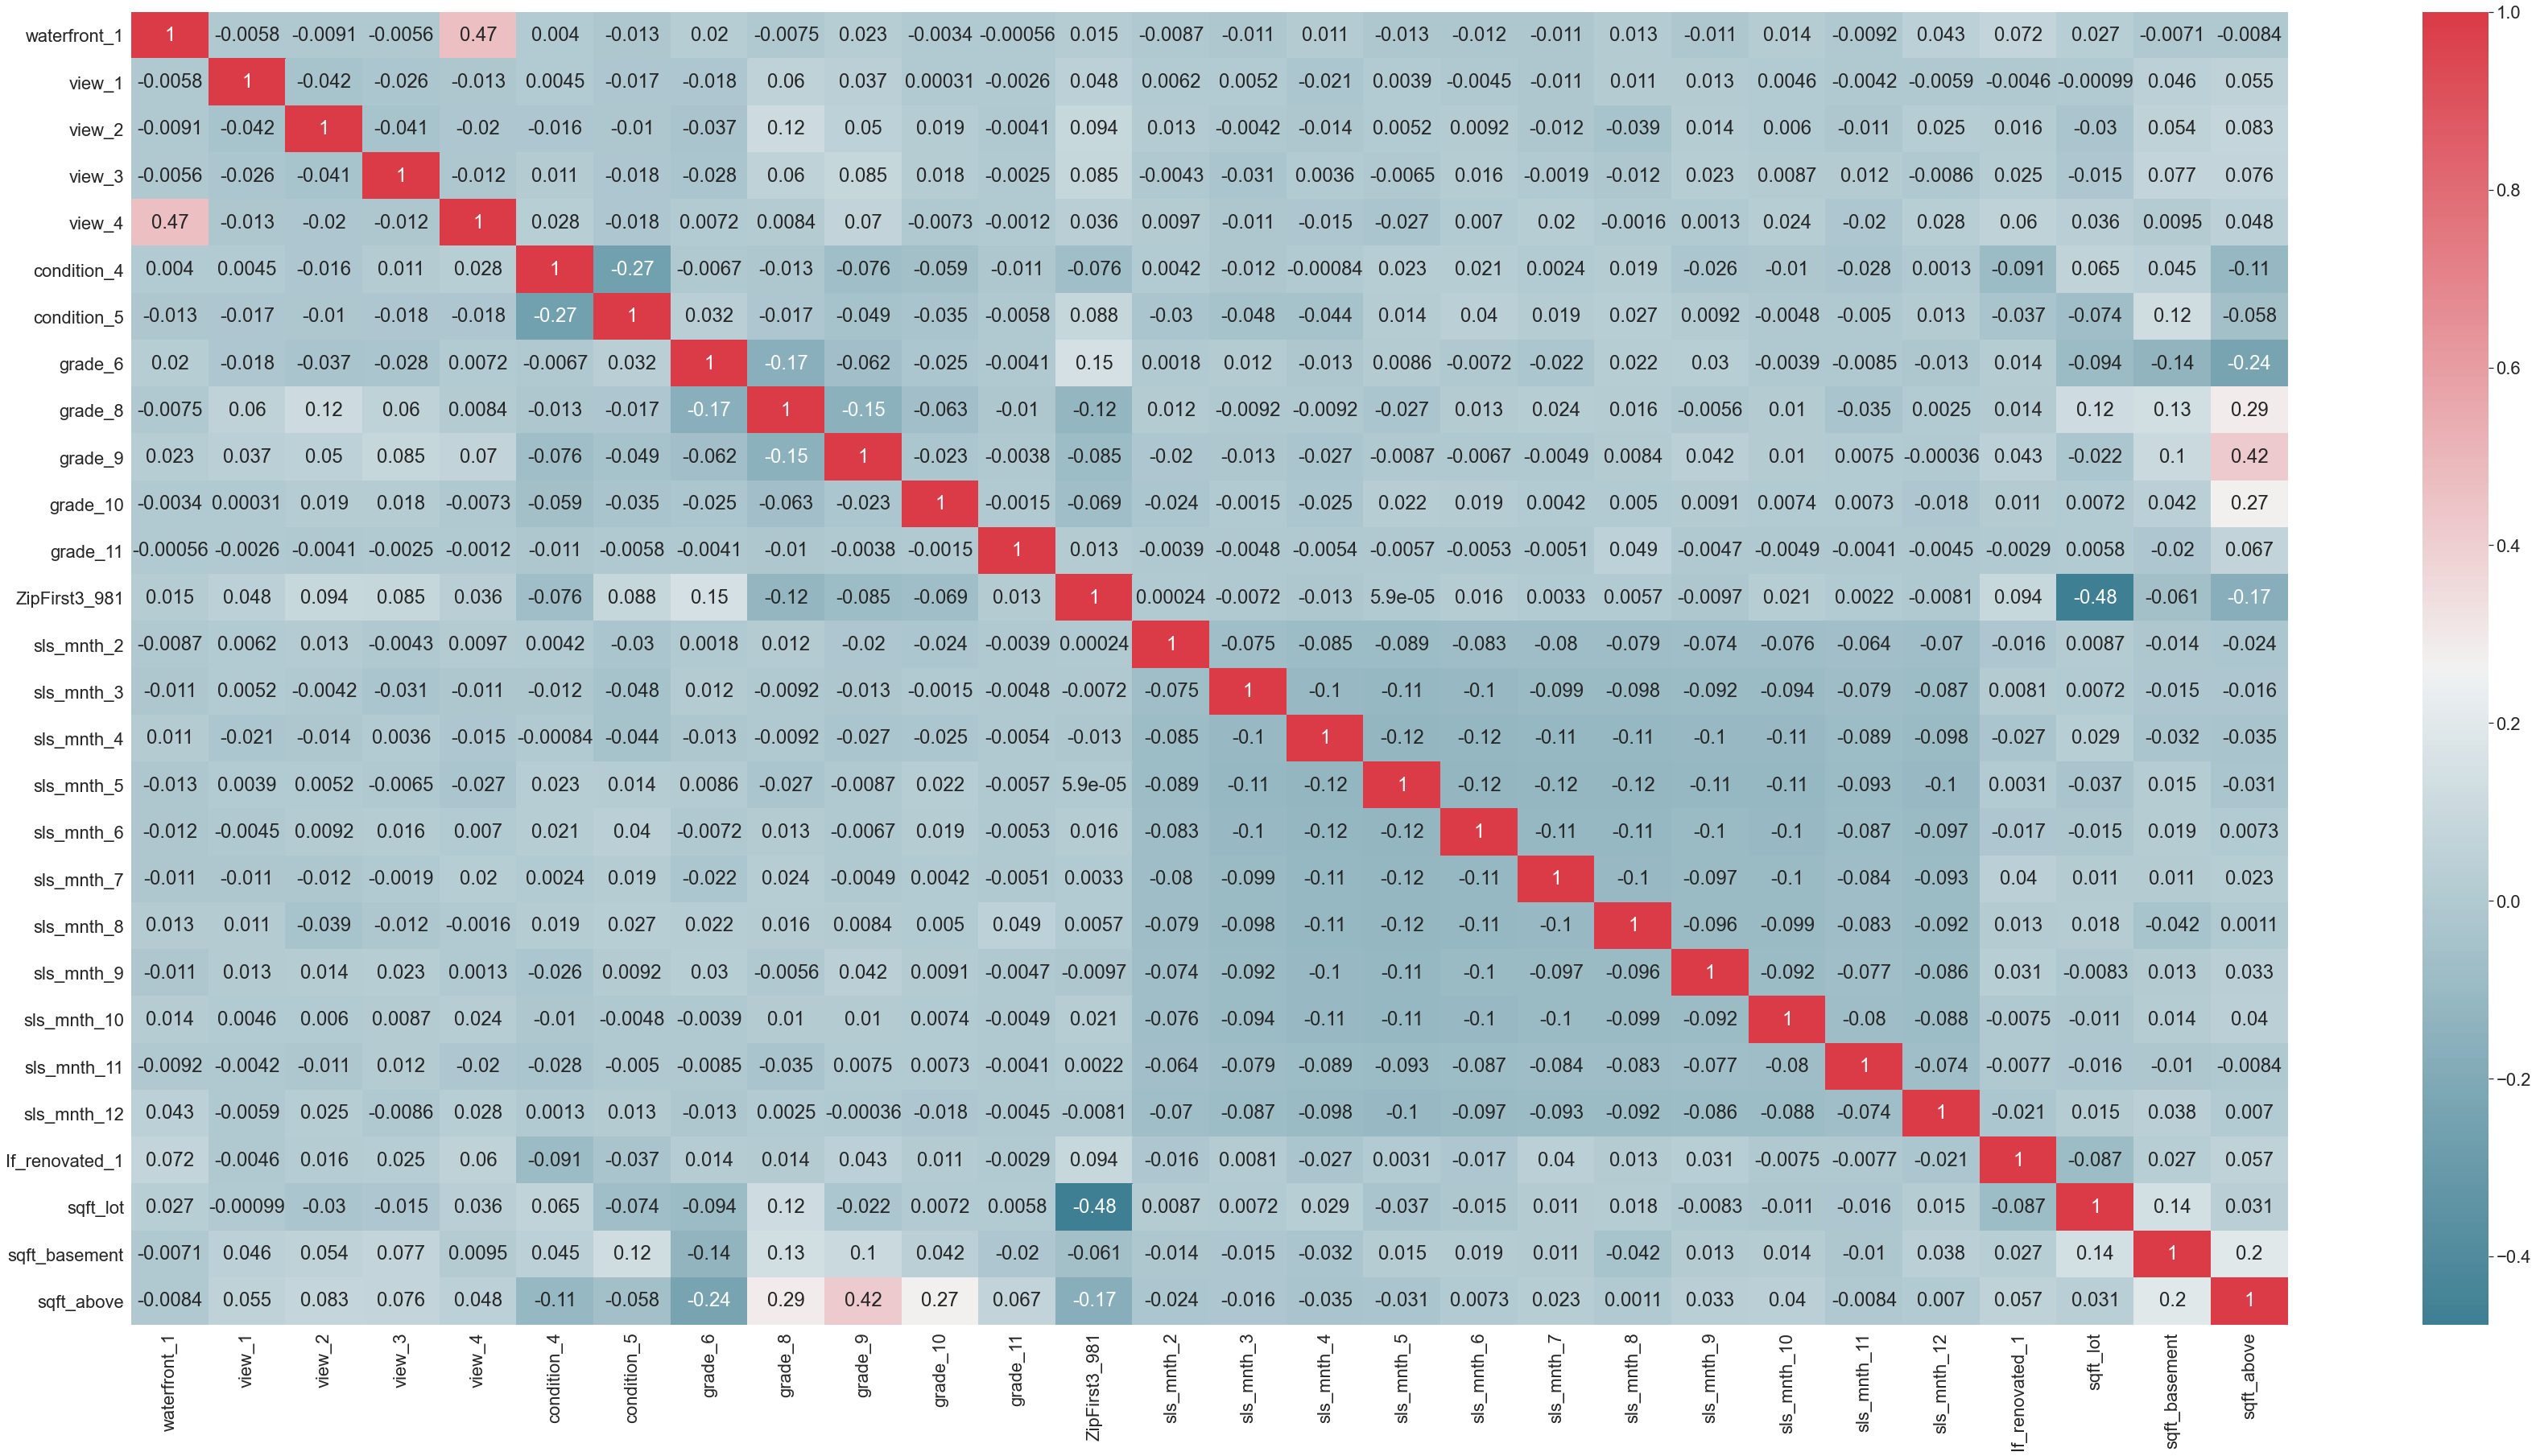

In [147]:
correlation_heatmap(data_Review_Colinearity_Model1)


# plt.figure(figsize=(12,12))
# # Compute the correlation matrix
# corr = df.corr()

# # Generate a mask for the upper triangle
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr, mask=mask, center=0, vmin=0.5, square=True, linewidths=.5, cmap='ocean')
# plt.title('Correlation between features', fontdict={'fontsize': 16})
# plt.show()

In [148]:
#Remove Columns from our list of continuous and Categorical values indentified in VIF and Colinear testing

# model1_Categorical_variables_to_remove = ['NA']
# model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


# model1_Continuous_variables_to_remove = ['sqft_above','sqft_living15','bathrooms','bedrooms']
# model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

# #Add newly created features to model
# data_Target_Homes_Scaled_WithDummies["ttl_Rooms"] = data_Review_Colinearity_Model1["ttl_Rooms"]
# model1_Continuous_variables.append("ttl_Rooms")
# data_Target_Homes_Scaled_WithDummies["sqft_Above_Combo"] = data_Review_Colinearity_Model1["sqft_Above_Combo"]
# model1_Continuous_variables.append("sqft_Above_Combo")

## New heading

##    C. Create Pickle of Dataset

Get All needed fields ready for Pickle file

In [149]:
FieldsMovingForward = ['id','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']

FieldsMovingForward.extend(data_Review_Colinearity_Model1.columns)
data_Target_Homes_Scaled_WithDummies = data_Target_Homes_Scaled_WithDummies[FieldsMovingForward]

Create Pickle File for testing Initial Model

In [150]:
with open('regression_Data_Initial_Model.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Scaled_WithDummies, f)

with open('regression_Data_xref.pickle', 'wb') as f:
    pickle.dump(data_Target_Homes_Not_Scaled_WithDummies, f)

In [151]:
pd.reset_option('display.float_format')
data_Target_Homes_Scaled_WithDummies.describe()

id          price     yr_built  yr_renovated       zipcode          lat         long    log_price  waterfront_1       view_1       view_2       view_3       view_4  condition_4  condition_5      grade_6      grade_8      grade_9     grade_10     grade_11  ZipFirst3_981   sls_mnth_2   sls_mnth_3   sls_mnth_4   sls_mnth_5   sls_mnth_6   sls_mnth_7   sls_mnth_8   sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1     sqft_lot  sqft_basement   sqft_above
count  3.999000e+03    3999.000000  3999.000000   3999.000000   3999.000000  3999.000000  3999.000000  3999.000000   3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000    3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000  3999.000000     3999.000000  3999.000000    3999.000000  3999.000000
mean   4.741245e+09  498918.235309  1959.734684     66.411603  98093.476369    47.589936  -122.267913    13.063824      0.001250     0.026507     0.061765     0.024506     0.005751     0.345586     0.117779     0.063766     0.297324     0.053263     0.009252     0.000250       0.593398     0.057264     0.085521     0.105276     0.115029     0.102526     0.095274     0.093023     0.082271     0.086522     0.062766     0.075519        0.033258     0.458313       0.332046     0.267530
std    2.857228e+09  165866.184106    24.494762    358.113401     55.705452     0.123680     0.106518     0.339230      0.035342     0.160656     0.240759     0.154634     0.075629     0.475619     0.322387     0.244366     0.457138     0.224586     0.095755     0.015813       0.491261     0.232376     0.279691     0.306948     0.319097     0.303376     0.293629     0.290501     0.274811     0.281168     0.242571     0.264260        0.179333     0.270701       0.147533     0.132404
min    3.600072e+06  245700.000000  1900.000000      0.000000  98001.000000    47.193700  -122.475000    12.411867      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.000000       0.000000     0.000000
25%    2.324539e+09  360000.000000  1945.000000      0.000000  98034.000000    47.518950  -122.354000    12.793859      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.218643       0.221198     0.180473
50%    4.058800e+09  475000.000000  1961.000000      0.000000  98108.000000    47.594300  -122.292000    13.071070      0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000       1.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.464857       0.322581     0.239645
75%    7.445750e+09  618750.000000  1977.000000      0.000000  98126.000000    47.692500  -122.191000    13.335456      0.000000     0.000000     0.000000     0.000000     0.000000     1.000000     0.000000     0.000000     1.000000     0.000000     0.000000     0.000000       1.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.664643       0.428571     0.316568
max    9.900000e+09  886000.000000  2015.000000   2015.000000  98199.000000    47.777600  -121.417000    13.694472      1

In [152]:
df_check2 = data_Target_Homes_Scaled_WithDummies.loc[data_Target_Homes_Scaled_WithDummies.waterfront_1 ==1]
df_check2

id        date     price  yr_built  yr_renovated  zipcode      lat     long  log_price  waterfront_1  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  grade_11  ZipFirst3_981  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  sqft_lot  sqft_basement  sqft_above
222   8069000075  12/29/2014  790000.0      1961           0.0    98178  47.5105 -122.238  13.579788             1       0       0       0       1            0            0        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               0  0.865857       0.483871    0.275148
2871  7558800620   8/22/2014  600000.0      1965        1986.0    98070  47.3580 -122.446  13.304685             1       0       0       0       1            1            0        0        1        0         0         0              0           0           0           0           0           0           0           1           0            0            0            0               1  0.537714       0.000000    0.316568
3151  8073000491  12/11/2014  700000.0      1957           0.0    98178  47.5121 -122.248  13.458836             1       0       0       0       1            0            0        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               0  0.448429       0.368664    0.198225
3493  3222049151  10/30/2014  820000.0      1976        1991.0    98198  47.3573 -122.324  13.617060             1       0       0       0       1            0            0        0        0        1         0         0              1           0           0           0           0           0           0           0           0            1            0            0               1  0.958714       0.658986    0.319527
3670  3222049087   4/22/2015  570000.0      1905           0.0    98198  47.3509 -122.323  13.253392             1       0       0       0       1            1            0        1        0        0         0         0              1           0           0           1           0           0           0           0           0            0            0            0               0  0.505714       0.000000    0.071006

# <u><font color='red'>Model 2 Dataset</font></u>

##    A. Adding Features - Location Based

Add additional Location Based features - Zip HotnessScores (HotnessScore), Count of Attractions with 7 miles of home(#1,#2,#3 attractions), School district for home and its rank (SchoolDistRank)

In [153]:
# Get Data From Above - Build Upon Model 1
with open('regression_Data_Initial_Model.pickle', 'rb') as file:
    data_Model2 = pickle.load(file)

In [154]:
#get Hotness Scores
df_Hotness_Zone = pd.read_excel("./data/ZIP_cube_HotnessZones.xlsx")
data_with_Hot = data_Model2.merge(df_Hotness_Zone[["zipcode","HotnessScore"]], on="zipcode", how="left")

#get School District & Rank
df_School_District_Info = pd.read_excel('./data/df_SchoolDistricts_SchoolDigger - all.xlsx', sheet_name='Export')
df_School_District_Ranking = pd.read_excel('./data/SchoolDisctrictRank.xlsx', sheet_name='Export')
df_School_Districts_withRank = df_School_District_Info.merge(df_School_District_Ranking, on="School District")
data_with_Hot_Dist = data_with_Hot.merge(df_School_Districts_withRank[["id","SchoolDistRankBin"]], on="id")
# data_with_Hot_Dist.rename(columns={"State Rank": "SchoolDistRank"})

#get points of interest within 7 miles
df_Points_Of_Interest = pd.read_excel('./data/df_points_of_int_CrossTab.xlsx')
data_with_Hot_Dist_POints = data_with_Hot_Dist.merge(df_Points_Of_Interest, on="id")
data_with_Hot_Dist_POints.rename(columns={1: "#1Attractions", 2: "#2Attractions", 3: "#3Attractions"}, inplace=True)

#get points of interest within 7 miles
df_Proximity_To_FortuneFives = pd.read_excel('./data/df_Counts_of_Fortune500_CrossTab.xlsx')
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.merge(df_Proximity_To_FortuneFives, on="id")


# fill in attraction columns 
data_with_Hot_Dist_POints['#1Attractions'].fillna(0, inplace=True)
data_with_Hot_Dist_POints['#2Attractions'].fillna(0, inplace=True)

data_with_Hot_Dist_POints.rename(columns={'#1Attractions':'Attractions1', '#2Attractions':'Attractions2', '#3Attractions':'Attractions3',
                                          'HotnessScore':'ZipHotnessScore'}, inplace=True)

data_with_Hot_Dist_POints.fillna(0, inplace=True)

In [155]:
data_with_Hot_Dist_POints.head()

id       date     price  yr_built  yr_renovated  zipcode      lat     long  log_price  waterfront_1  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  grade_11  ZipFirst3_981  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  sqft_lot  sqft_basement  sqft_above  ZipHotnessScore SchoolDistRankBin  Attractions1  Attractions2  Attractions3  Over10  Over20  Under10  Over7  Under7
0  6414100192  12/9/2014  538000.0      1951        1991.0    98125  47.7210 -122.319  13.195614             0       0       0       0       0            0            0        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               1  0.463143       0.184332    0.500000            87.31             Top30         154.0          37.0           957       4       1        6     10       1
1  2487200875  12/9/2014  604000.0      1965           0.0    98136  47.5208 -122.393  13.311329             0       0       0       0       0            0            1        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               0  0.142857       0.419355    0.168639            89.54             Top30         139.0          61.0           888       4       1        6      8       3
2  1736800520   4/3/2015  662500.0      1965           0.0    98007  47.6007 -122.145  13.403776             0       0       0       0       0            0            0        0        1        0         0         0              0           0           0           1           0           0           0           0           0            0            0            0               0  0.828000       0.783410    0.408284            88.67             Top15         132.0          39.0           738       2       1        8      7       4
3  9212900260  5/27/2014  468000.0      1942           0.0    98115  47.6900 -122.292  13.056224             0       0       0       0       0            1            0        0        0        0         0         0              1           0           0           0           1           0           0           0           0            0            0            0               0  0.285714       0.138249    0.112426            92.06             Top30         219.0          64.0          1574       4       0        7      6       5
4  9297300055  1/24/2015  650000.0      1979           0.0    98126  47.5714 -122.375  13.384728             0       0       0       1       0            0            0        0        0        1         0         0              1           0           0           0           0           0           0           0           0            0            0            0               0  0.142857       0.447005    0.443787            86.40             Top30         182.0          60.0          1350       4       1        6      7       4

##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [156]:
# model2_Continuous_variables  = ['ZipHotnessScore','Attractions1', 'Attractions2', 'Attractions3',
#                                'FFives_Under10', 'FFives_Over10', 'FFives_Over20']

model2_Continuous_variables  = ['ZipHotnessScore','Attractions1', 'Attractions2', 'Attractions3',
                               'Over10', 'Under10', 'Over20']


model2_Categorical_variables  = ['Sch_d_Top15','Sch_d_Top30', 'Sch_d_Top60']


data_with_Hot_Dist_POints_Continuous = data_with_Hot_Dist_POints[model2_Continuous_variables]

In [157]:
#Scale Continuous initial data
scaled_df_no_index2 , scaler_2 = scaleData_min_max (data_with_Hot_Dist_POints_Continuous)

In [158]:
#create dummies for new categorical
dummies_SchoolRankBins = pd.get_dummies(data_with_Hot_Dist_POints['SchoolDistRankBin'], prefix='Sch_d', drop_first=True)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints.drop('SchoolDistRankBin', axis=1)

#Add dummies back to main DF
data_with_Hot_Dist_POints_WithDummies = pd.concat([data_with_Hot_Dist_POints, dummies_SchoolRankBins], axis=1)

#drop original features that got scaled above
data_with_Hot_Dist_POints_WithDummies = data_with_Hot_Dist_POints_WithDummies.drop(model2_Continuous_variables, axis=1)

data_with_Hot_Dist_POints_WithDummies = data_with_Hot_Dist_POints_WithDummies.reset_index(drop=True)

#bring newly scaled and dummies together
data_with_Hot_Dist_POints = pd.concat([data_with_Hot_Dist_POints_WithDummies, scaled_df_no_index2], axis=1)

In [159]:
data_with_Hot_Dist_POints.head()

id       date     price  yr_built  yr_renovated  zipcode      lat     long  log_price  waterfront_1  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  grade_11  ZipFirst3_981  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  sqft_lot  sqft_basement  sqft_above  Over7  Under7  Sch_d_Top15  Sch_d_Top30  Sch_d_Top60  ZipHotnessScore  Attractions1  Attractions2  Attractions3  Over10   Under10  Over20
0  6414100192  12/9/2014  538000.0      1951        1991.0    98125  47.7210 -122.319  13.195614             0       0       0       0       0            0            0        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               1  0.463143       0.184332    0.500000     10       1            0            1            0         0.783658      0.340961      0.258993      0.281948   0.250  0.428571    0.05
1  2487200875  12/9/2014  604000.0      1965           0.0    98136  47.5208 -122.393  13.311329             0       0       0       0       0            0            1        0        0        0         0         0              1           0           0           0           0           0           0           0           0            0            0            1               0  0.142857       0.419355    0.168639      8       3            0            1            0         0.833038      0.306636      0.431655      0.260546   0.250  0.428571    0.05
2  1736800520   4/3/2015  662500.0      1965           0.0    98007  47.6007 -122.145  13.403776             0       0       0       0       0            0            0        0        1        0         0         0              0           0           0           1           0           0           0           0           0            0            0            0               0  0.828000       0.783410    0.408284      7       4            1            0            0         0.813773      0.290618      0.273381      0.214020   0.125  0.571429    0.05
3  9212900260  5/27/2014  468000.0      1942           0.0    98115  47.6900 -122.292  13.056224             0       0       0       0       0            1            0        0        0        0         0         0              1           0           0           0           1           0           0           0           0            0            0            0               0  0.285714       0.138249    0.112426      6       5            0            1            0         0.888840      0.489703      0.453237      0.473325   0.250  0.500000    0.00
4  9297300055  1/24/2015  650000.0      1979           0.0    98126  47.5714 -122.375  13.384728             0       0       0       1       0            0            0        0        0        1         0         0              1           0           0           0           0           0           0           0           0            0            0            0               0  0.142857       0.447005    0.443787      7       4            0            1            0         0.763508      0.405034      0.424460      0.403846   0.250  0.428571    0.05

Check For Colinearity - feed all relevant categorical and dummy variables into colinearity review

In [160]:
model1_Categorical_variables_to_remove = ['waterfront_1']
# model2_Categorical_variables = model1_Categorical_variables
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model2_Categorical_variables_to_remove = ['NA']
# model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['NA']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

cc
pairs                                     
(Attractions1, Attractions3)      0.949232
(Attractions3, Attractions2)      0.934397
(Attractions2, Attractions1)      0.925191
(Attractions1, Under10)           0.842453
(Attractions3, Sch_d_Top30)       0.808297
(ZipHotnessScore, ZipFirst3_981)  0.790261
(Under10, Attractions2)           0.778768
(Sch_d_Top30, ZipFirst3_981)      0.765119
(Under10, Attractions3)           0.762522
(Attractions2, Sch_d_Top30)       0.737513

In [161]:
vifResults2 = checkForVIF(data_Review_Colinearity_Model2)
vifResults2

[('Sch_d_Top15', 3.294061847824656),
 ('Sch_d_Top30', 11.408616268629569),
 ('Sch_d_Top60', 1.6485323774180314),
 ('ZipHotnessScore', 45.90647080082968),
 ('Attractions1', 218.39987519872196),
 ('Attractions2', 67.52792862928253),
 ('Attractions3', 144.87503200251788),
 ('Over10', 18.825558991334976),
 ('Under10', 54.51554492731085),
 ('Over20', 3.6379978554352883),
 ('sqft_lot', 6.817665804441693),
 ('sqft_basement', 6.873994932948379),
 ('sqft_above', 9.019741063931475),
 ('view_1', 1.0578499594804038),
 ('view_2', 1.1305463850462547),
 ('view_3', 1.081004021493506),
 ('view_4', 1.035244563921643),
 ('condition_4', 1.755059843453107),
 ('condition_5', 1.3068937691954632),
 ('grade_6', 1.1953958320489837),
 ('grade_8', 1.954922563011756),
 ('grade_9', 1.5725231070248953),
 ('grade_10', 1.1882866561632108),
 ('grade_11', 1.0157740050790005),
 ('ZipFirst3_981', 13.205672191797301),
 ('sls_mnth_2', 2.4034164361110864),
 ('sls_mnth_3', 3.048270701513912),
 ('sls_mnth_4', 3.508148797823197

Drop 

In [162]:
model1_Categorical_variables_to_remove = ['ZipFirst3_981','grade_11']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]

model1_Continuous_variables_to_remove = ['AgeOfHome']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove)]

# model2_Categorical_variables = model1_Categorical_variables
model2_Categorical_variables_to_remove = ['NA']
model2_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model2_Categorical_variables_to_remove)]

model2_Continuous_variables_to_remove = ['Attractions2','Attractions3', 'Attractions1','ZipHotnessScore','Over10']
model2_Continuous_variables = [e for e in model2_Continuous_variables if e not in (model2_Continuous_variables_to_remove)]

colstoCheck = model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model2 = data_with_Hot_Dist_POints[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model2)
df_fromCheck

Empty DataFrame
Columns: [cc]
Index: []

In [163]:
data_Review_Colinearity_Model2.head()

Sch_d_Top15  Sch_d_Top30  Sch_d_Top60   Under10  Over20  sqft_lot  sqft_basement  sqft_above  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1
0            0            1            0  0.428571    0.05  0.463143       0.184332    0.500000       0       0       0       0            0            0        0        0        0         0           0           0           0           0           0           0           0           0            0            0            1               1
1            0            1            0  0.428571    0.05  0.142857       0.419355    0.168639       0       0       0       0            0            1        0        0        0         0           0           0           0           0           0           0           0           0            0            0            1               0
2            1            0            0  0.571429    0.05  0.828000       0.783410    0.408284       0       0       0       0            0            0        0        1        0         0           0           0           1           0           0           0           0           0            0            0            0               0
3            0            1            0  0.500000    0.00  0.285714       0.138249    0.112426       0       0       0       0            1            0        0        0        0         0           0           0           0           1           0           0           0           0            0            0            0               0
4            0            1            0  0.428571    0.05  0.142857       0.447005    0.443787       0       0       1       0            0            0        0        0        1         0           0           0           0           0           0           0           0           0            0            0            0               0

In [164]:
vifResults2 = checkForVIF(data_Review_Colinearity_Model2)
vifResults2

[('Sch_d_Top15', 2.7186146901018264),
 ('Sch_d_Top30', 5.093992383258621),
 ('Sch_d_Top60', 1.3559239177914264),
 ('Under10', 9.176506747642463),
 ('Over20', 2.320156939572101),
 ('sqft_lot', 5.722396174423057),
 ('sqft_basement', 6.646888672290805),
 ('sqft_above', 8.275287807689693),
 ('view_1', 1.0488977937572177),
 ('view_2', 1.1173086777101275),
 ('view_3', 1.0660628866273985),
 ('view_4', 1.0263008102327187),
 ('condition_4', 1.7137546204221925),
 ('condition_5', 1.3021949108066244),
 ('grade_6', 1.1609321829045116),
 ('grade_8', 1.8968698237131072),
 ('grade_9', 1.5250178735868016),
 ('grade_10', 1.1687436646248175),
 ('sls_mnth_2', 1.873623427792257),
 ('sls_mnth_3', 2.2540078399834016),
 ('sls_mnth_4', 2.5854341622097823),
 ('sls_mnth_5', 2.7565988970649387),
 ('sls_mnth_6', 2.5945069983073994),
 ('sls_mnth_7', 2.4712569989026636),
 ('sls_mnth_8', 2.4249195391670537),
 ('sls_mnth_9', 2.291041740009964),
 ('sls_mnth_10', 2.3729642158454776),
 ('sls_mnth_11', 1.9567479619974453)

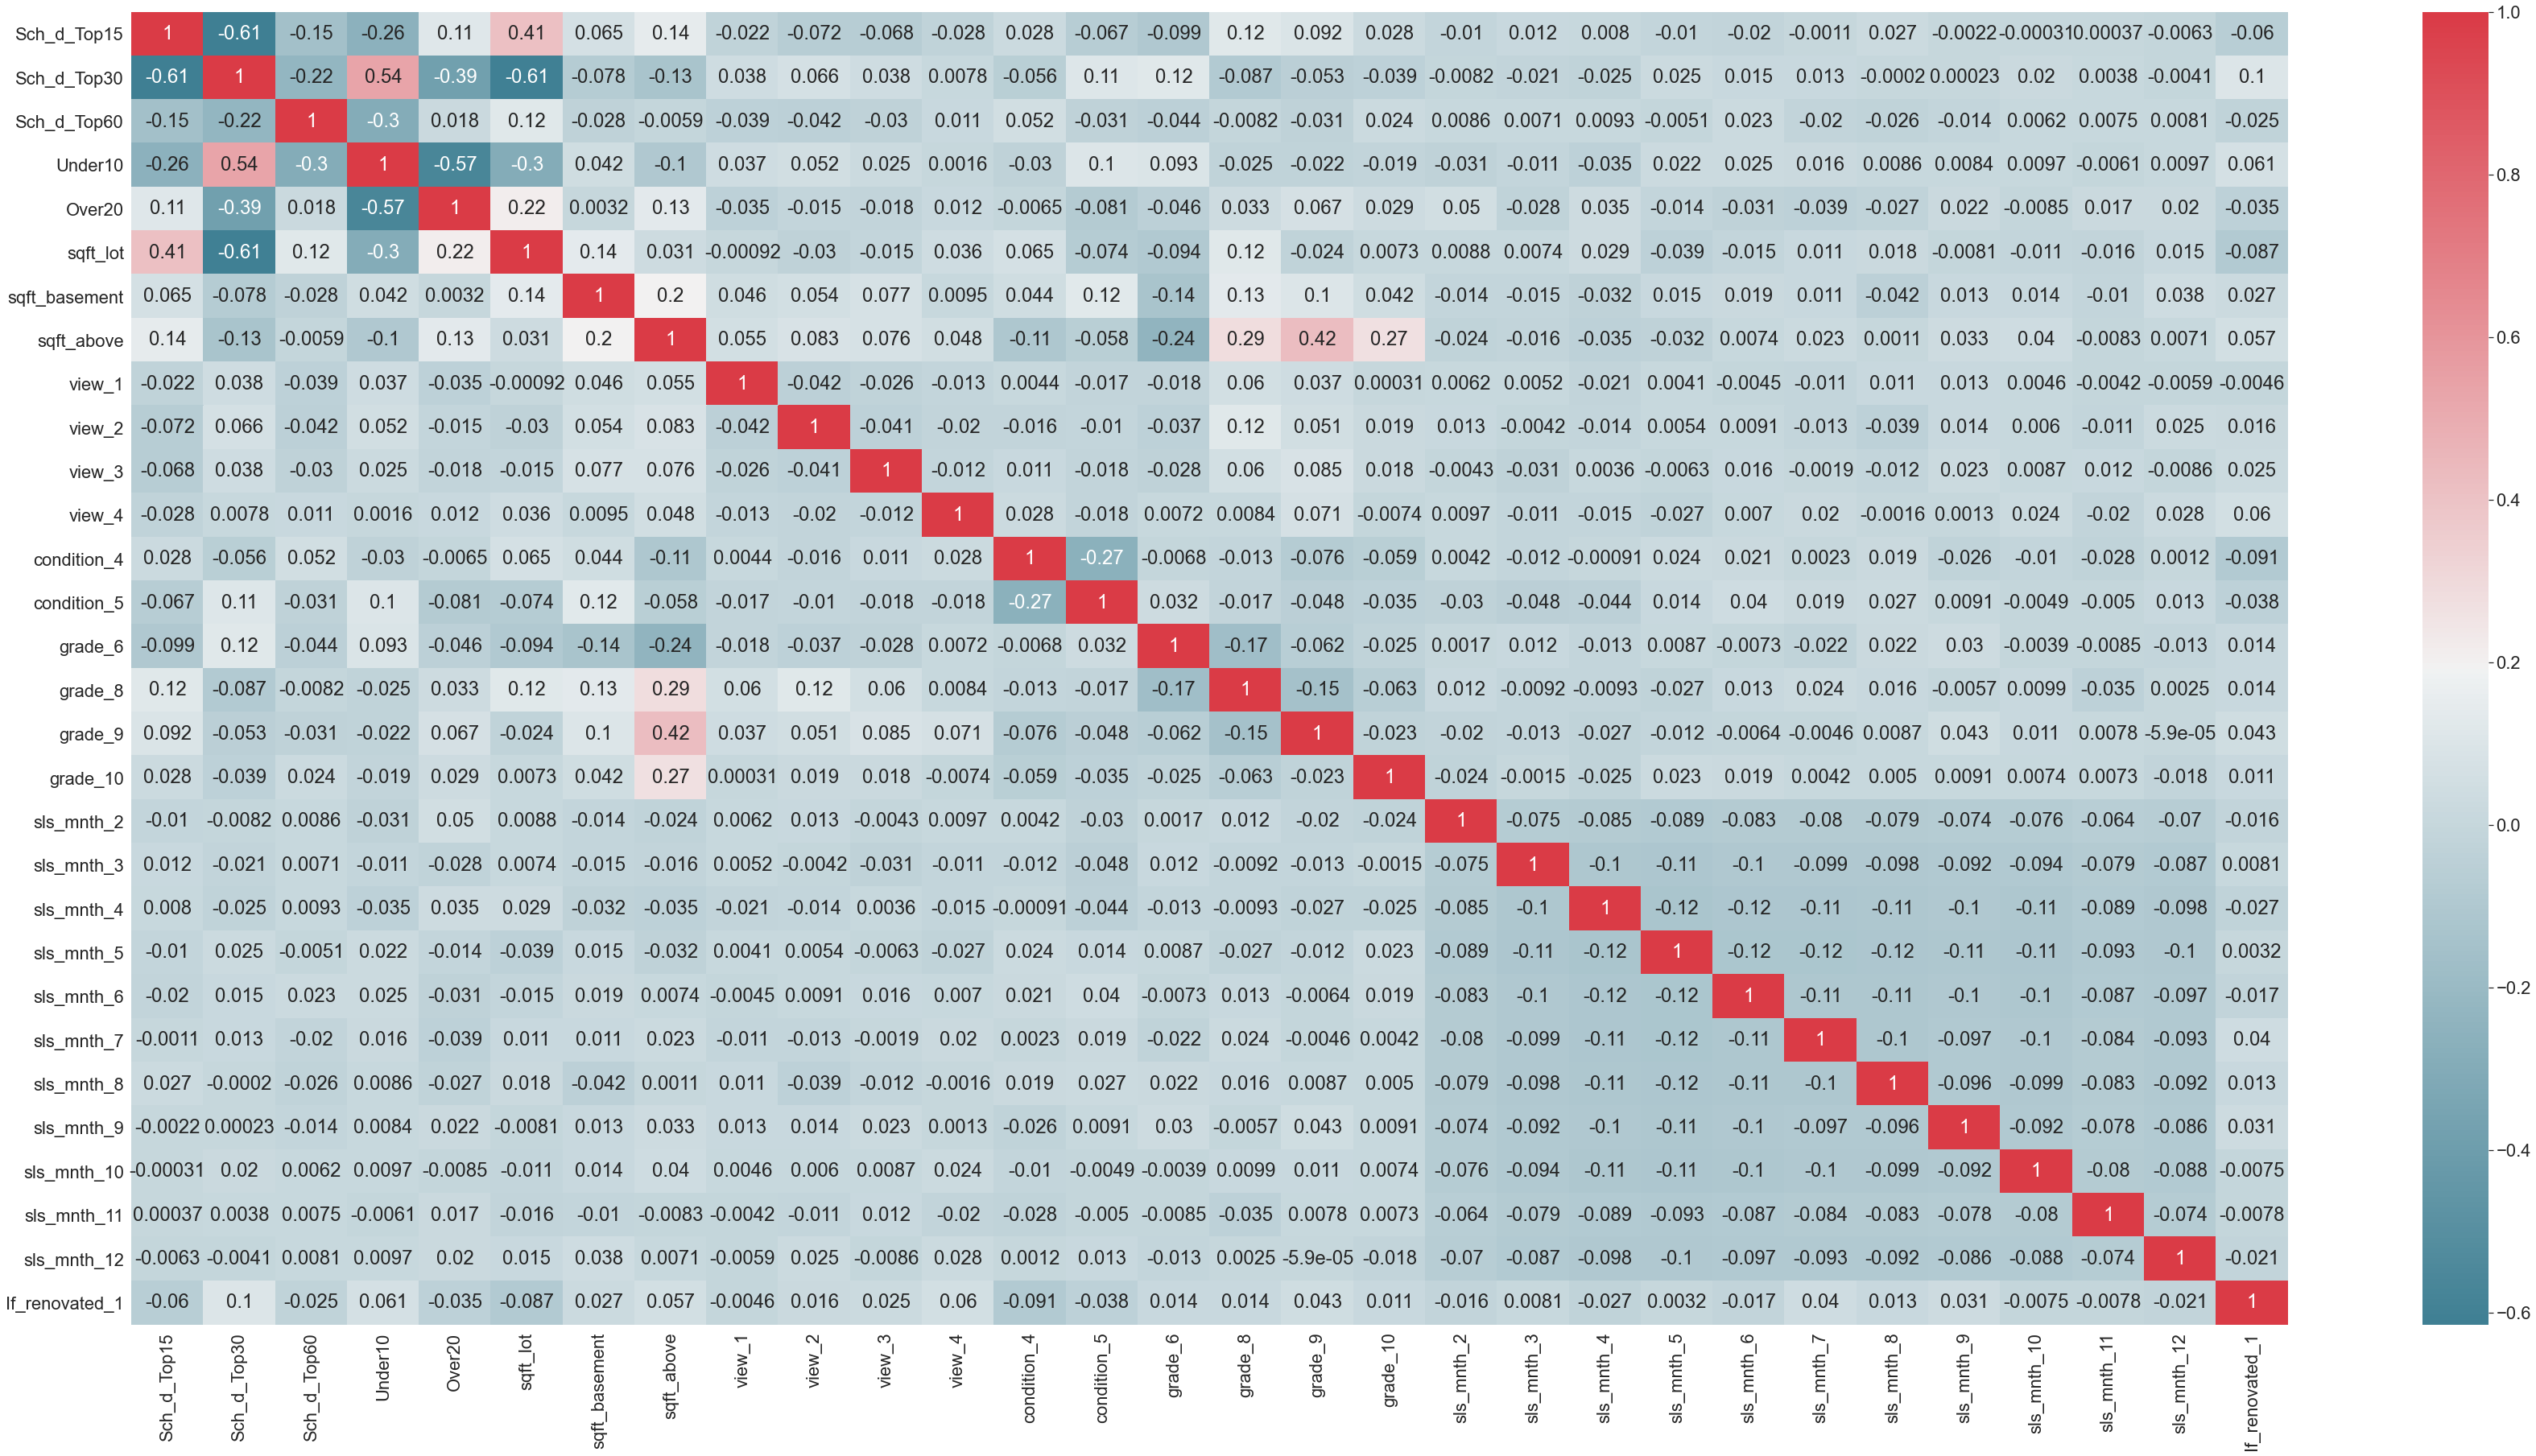

In [165]:
correlation_heatmap(data_Review_Colinearity_Model2)

##     C. Create Pickle of Dataset

In [166]:
FieldsMovingForward = ['id','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']
FieldsMovingForward.extend(data_Review_Colinearity_Model2.columns)
data_with_Hot_Dist_POints = data_with_Hot_Dist_POints[FieldsMovingForward]

In [167]:
import pickle
# Save
with open('regression_Data_Second_Model.pickle', 'wb') as f:
    pickle.dump(data_with_Hot_Dist_POints, f)

# <u> <font color='red'>Model 3 Dataset</font> </u>

## A. Adding Features - Previous Year Assesor Values

Add additional previous yr county assessor valuation - AppraisedLandValue, AppraisedImpsValue(aka house value), LandToHouseCheck, InflationSinceLastAppraisal

In [168]:
# Get Data From Above - Build Upon Model 2

# Load Data From Pickel
with open('regression_Data_Second_Model.pickle', 'rb') as file:
    data_Model3 = pickle.load(file)

In [169]:
data_Model3['salesyear'] = pd.DatetimeIndex(data_Model3['date']).year
data_Model3['yearpriortosale'] = data_Model3['salesyear'] - 1
data_Model3["yearpriortosale_str"] = data_Model3["yearpriortosale"].astype('str')
data_Model3["id_str"] = data_Model3["id"].astype('str')
data_Model3['appraisalKey'] = data_Model3['id_str'] + data_Model3['yearpriortosale_str']

#get Appraisal Data - inner join to eleminate valus with no appraisals
df_Appraisal_Info = pd.read_excel('./data/Appraisals_Values_Table_w_3yrRolling.xlsx')
df_Appraisal_Info["appraisalKey"] = df_Appraisal_Info["appraisalKey"].astype('str')
df_data_with_Appraisals = data_Model3.merge(df_Appraisal_Info[['YrRollingAppraisal','AppraisedLandValue','AppraisedImpsValue','AppraisedTotal','LandToHouseCheck','InflationSinceLastAppraisal','InflationSinceLastAppraisal_abs','appraisalKey']], on="appraisalKey", how="inner")

df_data_with_Appraisals.drop(['appraisalKey', 'id_str', 'salesyear', 'yearpriortosale_str', 'yearpriortosale'], axis=1, inplace=True)

In [170]:
#Remove addtiaional outliers, "abnarmally" expensive, big, etc. homes 
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['LandToHouseCheck'] <= .6]
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['InflationSinceLastAppraisal_abs'] <= .10]
df_data_with_Appraisals = df_data_with_Appraisals.loc[df_data_with_Appraisals['AppraisedTotal'] <= 850000]
# df_data_with_Appraisals = df_data_with_Appraisals.loc[(250000 <= df_data_with_Appraisals['AppraisedTotal']) & (df_data_with_Appraisals['AppraisedTotal'] <= 850000)]


In [171]:
df_data_with_Appraisals.describe()

id          price     yr_built  yr_renovated       zipcode          lat         long    log_price  Sch_d_Top15  Sch_d_Top30  Sch_d_Top60      Under10       Over20     sqft_lot  sqft_basement   sqft_above       view_1       view_2       view_3       view_4  condition_4  condition_5      grade_6      grade_8      grade_9     grade_10   sls_mnth_2   sls_mnth_3   sls_mnth_4   sls_mnth_5   sls_mnth_6   sls_mnth_7   sls_mnth_8   sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  YrRollingAppraisal  AppraisedLandValue  AppraisedImpsValue  AppraisedTotal  LandToHouseCheck  InflationSinceLastAppraisal  InflationSinceLastAppraisal_abs
count  1.827000e+03    1827.000000  1827.000000   1827.000000   1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000    1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000     1827.000000         1827.000000         1827.000000         1827.000000     1827.000000       1827.000000                  1827.000000                      1827.000000
mean   5.189408e+09  462127.470170  1962.967159     57.817734  98096.760263    47.552903  -122.271866    12.982899     0.227148     0.431856     0.058566     0.339471     0.089491     0.453543       0.335066     0.279743     0.026273     0.059661     0.027915     0.005473     0.339901     0.102354     0.044335     0.294472     0.061850     0.007663     0.057471     0.082102     0.113300     0.110564     0.101806     0.088670     0.087575     0.081007     0.092501     0.068966     0.073344        0.029009       324462.314724       151734.099617       196042.145594   347776.245211          0.434622                     0.045062                         0.056548
std    2.690441e+09  164549.728618    24.267811    334.605838     51.891226     0.135990     0.109145     0.346380     0.419104     0.495470     0.234875     0.191437     0.109984     0.264305       0.147437     0.136339     0.159989     0.236922     0.164773     0.073800     0.473805     0.303196     0.205895     0.455930     0.240949     0.087225     0.232805     0.274595     0.317047     0.313677     0.302476     0.284345     0.282754     0.272921     0.289812     0.253465     0.260772        0.167879       122439.216326        67713.546534        84635.018719   135826.289239          0.088365                     0.045759                         0.030432
min    1.024049e+09  245700.000000  1900.000000      0.000000  98001.000000    47.193700  -122.456000    12.411867     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000       0.050691     0.032544     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000        15333.000000        45000.000000        57000.000000   135000.000000          0.150729                    -0.098361                         0.000000
25%    2.767803e+09  325169.000000  1949.000000      0.000000  98052.000000    47.462800  -122.353000    12.692100     0.000000     0.000000     0.000000     0.142857     0.050000     0.224143       0.228111     0.189349     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000       226333.000000        93000.000000       134000.000000   239000.000000          0.370464                     0.014085                         0.032715
50%    5.100401e+09  

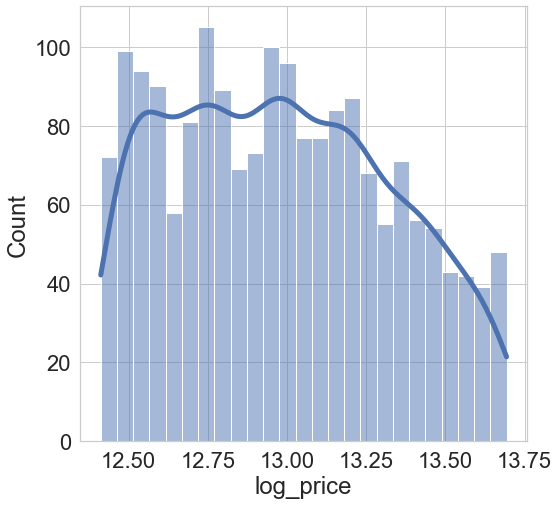

In [172]:
#distribution of Target/ dependent
fig = plt.figure(figsize = (8,8))
ax = fig.gca()
sns.histplot(x= "log_price",
             data=df_data_with_Appraisals,
             bins=25,
             kde=True,
             line_kws={"linewidth":5}, ax=ax, )
plt.show()

##     B. Scaling, Converting & Eliminating Multicolinearity

Prepare To Scale New Features

In [173]:
model3_Continuous_variables  = ['YrRollingAppraisal','AppraisedLandValue', 
                                  'AppraisedImpsValue', 'LandToHouseCheck',
                                  'InflationSinceLastAppraisal', 
                                  'InflationSinceLastAppraisal_abs']


data_with_Appraisals_Continuous = df_data_with_Appraisals[model3_Continuous_variables]

In [174]:
# Scale new continuous variables
scaled_df_no_index3, scaler_3 = scaleData_min_max (data_with_Appraisals_Continuous)

In [175]:
df_data_with_Appraisals = df_data_with_Appraisals.drop(model3_Continuous_variables, axis=1)
df_data_with_Appraisals = df_data_with_Appraisals.reset_index(drop=True)
df_data_with_Appraisals = pd.concat([df_data_with_Appraisals, scaled_df_no_index3], axis=1)

In [176]:
df_data_with_Appraisals.head()

id        date     price  yr_built  yr_renovated  zipcode      lat     long  log_price  Sch_d_Top15  Sch_d_Top30  Sch_d_Top60   Under10  Over20  sqft_lot  sqft_basement  sqft_above  view_1  view_2  view_3  view_4  condition_4  condition_5  grade_6  grade_8  grade_9  grade_10  sls_mnth_2  sls_mnth_3  sls_mnth_4  sls_mnth_5  sls_mnth_6  sls_mnth_7  sls_mnth_8  sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1  AppraisedTotal  YrRollingAppraisal  AppraisedLandValue  AppraisedImpsValue  LandToHouseCheck  InflationSinceLastAppraisal  InflationSinceLastAppraisal_abs
0  2487200875   12/9/2014  604000.0      1965           0.0    98136  47.5208 -122.393  13.311329            0            1            0  0.428571    0.05  0.142857       0.419355    0.168639       0       0       0       0            0            1        0        0        0         0           0           0           0           0           0           0           0           0            0            0            1               0          351000            0.422462            0.279012            0.243292          0.666443                     0.932886                         0.866873
1  9297300055   1/24/2015  650000.0      1979           0.0    98126  47.5714 -122.375  13.384728            0            1            0  0.428571    0.05  0.142857       0.447005    0.443787       0       0       1       0            0            0        0        0        1         0           0           0           0           0           0           0           0           0            0            0            0               0          759000            0.819870            0.674074            0.686941          0.597063                     0.990773                         0.981697
2  1432701230   7/29/2014  309000.0      1959           0.0    98058  47.4485 -122.175  12.641097            0            0            0  0.214286    0.05  0.808000       0.165899    0.130178       0       0       0       0            1            0        1        0        0         0           0           0           0           0           0           1           0           0            0            0            0               0          176000            0.203024            0.049383            0.096601          0.486542                     1.000000                         1.000000
3  7231300125   2/17/2015  345000.0      1966           0.0    98056  47.4934 -122.189  12.751300            0            0            0  0.428571    0.05  0.733429       0.695853    0.343195       0       0       0       0            1            0        0        1        0         0           1           0           0           0           0           0           0           0            0            0            0               0          340000            0.329590            0.288889            0.216458          0.725045                     0.495868                         0.000000
4  9418400240  10/28/2014  355000.0      1948           0.0    98118  47.5474 -122.291  12.779873            0            1            0  0.571429    0.05  0.388571       0.465438    0.156805       0       0       0       0            0            0        0        0        0         0           0           0           0           0           0           0           0           0            1            0            0               0          242000            0.307127            0.180247            0.119857          0.749824                     0.495868                         0.000000

Check For Colinearity

In [177]:
model1_Categorical_variables

['view_1',
 'view_2',
 'view_3',
 'view_4',
 'condition_4',
 'condition_5',
 'grade_6',
 'grade_8',
 'grade_9',
 'grade_10',
 'sls_mnth_2',
 'sls_mnth_3',
 'sls_mnth_4',
 'sls_mnth_5',
 'sls_mnth_6',
 'sls_mnth_7',
 'sls_mnth_8',
 'sls_mnth_9',
 'sls_mnth_10',
 'sls_mnth_11',
 'sls_mnth_12',
 'If_renovated_1']

In [178]:
# model3_Categorical_variables_to_remove = ['NA']
# model3_Categorical_variables = model2_Categorical_variables
# model3_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model3_Categorical_variables_to_remove)]

model3_Continuous_variables_to_remove = ['NA']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Continuous_variables + model2_Categorical_variables + model2_Continuous_variables + model1_Continuous_variables + model1_Categorical_variables

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

cc
pairs                                                                   
(YrRollingAppraisal, AppraisedImpsValue)                        0.863110
(AppraisedLandValue, YrRollingAppraisal)                        0.850134
(InflationSinceLastAppraisal, InflationSinceLastAppraisal_abs)  0.720593
(Under10, Sch_d_Top30)                                          0.701590

In [179]:
vifResults3 = checkForVIF(data_Review_Colinearity_Model3)
vifResults3

[('YrRollingAppraisal', 189.34474056083855),
 ('AppraisedLandValue', 38.28583250737993),
 ('AppraisedImpsValue', 69.2543442822202),
 ('LandToHouseCheck', 53.50812348090423),
 ('InflationSinceLastAppraisal', 24.793345524434148),
 ('InflationSinceLastAppraisal_abs', 10.000854318424945),
 ('Sch_d_Top15', 2.643118192386938),
 ('Sch_d_Top30', 7.083165432439228),
 ('Sch_d_Top60', 1.4361757877876054),
 ('Under10', 12.203891505787816),
 ('Over20', 3.0196869128825097),
 ('sqft_lot', 6.743480955473699),
 ('sqft_basement', 7.125079822985203),
 ('sqft_above', 15.00638513138225),
 ('view_1', 1.0736985878993053),
 ('view_2', 1.154074739767049),
 ('view_3', 1.149172396649144),
 ('view_4', 1.0542419021800944),
 ('condition_4', 1.8225975283502578),
 ('condition_5', 1.288465545681006),
 ('grade_6', 1.1904910556568786),
 ('grade_8', 2.1747520761424726),
 ('grade_9', 1.8889899087443185),
 ('grade_10', 1.1691358760932922),
 ('sls_mnth_2', 2.2172653691891355),
 ('sls_mnth_3', 2.704272163291088),
 ('sls_mnth

In [180]:
model1_Categorical_variables_to_remove = ['waterfront_1']
model1_Categorical_variables = [e for e in model1_Categorical_variables if e not in (model1_Categorical_variables_to_remove)]


model1_Continuous_variables_to_remove_v1 = ['NA']
model1_Continuous_variables = [e for e in model1_Continuous_variables if e not in (model1_Continuous_variables_to_remove_v1)]

# model3_Categorical_variables_to_remove = ['NA']
# model3_Categorical_variables = model2_Categorical_variables
# model3_Categorical_variables = [e for e in model2_Categorical_variables if e not in (model3_Categorical_variables_to_remove)]

model3_Continuous_variables_to_remove = ['YrRollingAppraisal','InflationSinceLastAppraisal_abs','LandToHouseCheck',
                                         'InflationSinceLastAppraisal']
model3_Continuous_variables = [e for e in model3_Continuous_variables if e not in (model3_Continuous_variables_to_remove)]

colstoCheck = model3_Continuous_variables + model2_Categorical_variables + model2_Continuous_variables + model1_Categorical_variables + model1_Continuous_variables 

data_Review_Colinearity_Model3 = df_data_with_Appraisals[colstoCheck]
df_fromCheck = checkForColinearity (data_Review_Colinearity_Model3)
df_fromCheck

cc
pairs                          
(Under10, Sch_d_Top30)  0.70159

In [181]:
data_Review_Colinearity_Model3["AssesorAppraisals"] = data_Review_Colinearity_Model3['AppraisedLandValue']*data_Review_Colinearity_Model3['AppraisedImpsValue']
data_Review_Colinearity_Model3 = data_Review_Colinearity_Model3.drop(['AppraisedLandValue','AppraisedImpsValue'], axis=1)
df_data_with_Appraisals["AssesorAppraisals"] = data_Review_Colinearity_Model3["AssesorAppraisals"]

<ipython-input-181-a660f05b2842>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_Review_Colinearity_Model3["AssesorAppraisals"] = data_Review_Colinearity_Model3['AppraisedLandValue']*data_Review_Colinearity_Model3['AppraisedImpsValue']


In [182]:
vifResults3 = checkForVIF(data_Review_Colinearity_Model3)
vifResults3

[('Sch_d_Top15', 2.104135420301835),
 ('Sch_d_Top30', 5.632015525108525),
 ('Sch_d_Top60', 1.3159600712295945),
 ('Under10', 10.012342730371662),
 ('Over20', 2.7036380542881675),
 ('view_1', 1.0628491374705347),
 ('view_2', 1.1201821250100392),
 ('view_3', 1.1163232688091966),
 ('view_4', 1.0453745025535628),
 ('condition_4', 1.7529973266024772),
 ('condition_5', 1.276814648597587),
 ('grade_6', 1.1363171458435513),
 ('grade_8', 2.0106026614812875),
 ('grade_9', 1.8187117085789457),
 ('grade_10', 1.1487578863458994),
 ('sls_mnth_2', 1.8804981403003387),
 ('sls_mnth_3', 2.177784124105831),
 ('sls_mnth_4', 2.6431267449897815),
 ('sls_mnth_5', 2.646765310573062),
 ('sls_mnth_6', 2.542462017463002),
 ('sls_mnth_7', 2.3429722471023267),
 ('sls_mnth_8', 2.2808155807554815),
 ('sls_mnth_9', 2.2702290174486266),
 ('sls_mnth_10', 2.4796352031054174),
 ('sls_mnth_11', 2.0657636311345815),
 ('sls_mnth_12', 2.1360628902111802),
 ('If_renovated_1', 1.0771819907329692),
 ('sqft_lot', 5.8421591864294

In [183]:
data_Review_Colinearity_Model3.describe()

Sch_d_Top15  Sch_d_Top30  Sch_d_Top60      Under10       Over20       view_1       view_2       view_3       view_4  condition_4  condition_5      grade_6      grade_8      grade_9     grade_10   sls_mnth_2   sls_mnth_3   sls_mnth_4   sls_mnth_5   sls_mnth_6   sls_mnth_7   sls_mnth_8   sls_mnth_9  sls_mnth_10  sls_mnth_11  sls_mnth_12  If_renovated_1     sqft_lot  sqft_basement   sqft_above  AssesorAppraisals
count  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000  1827.000000     1827.000000  1827.000000    1827.000000  1827.000000        1827.000000
mean      0.227148     0.431856     0.058566     0.339471     0.089491     0.026273     0.059661     0.027915     0.005473     0.339901     0.102354     0.044335     0.294472     0.061850     0.007663     0.057471     0.082102     0.113300     0.110564     0.101806     0.088670     0.087575     0.081007     0.092501     0.068966     0.073344        0.029009     0.453543       0.335066     0.279743           0.080342
std       0.419104     0.495470     0.234875     0.191437     0.109984     0.159989     0.236922     0.164773     0.073800     0.473805     0.303196     0.205895     0.455930     0.240949     0.087225     0.232805     0.274595     0.317047     0.313677     0.302476     0.284345     0.282754     0.272921     0.289812     0.253465     0.260772        0.167879     0.264305       0.147437     0.136339           0.088257
min       0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.000000       0.050691     0.032544           0.000000
25%       0.000000     0.000000     0.000000     0.142857     0.050000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.224143       0.228111     0.189349           0.017094
50%       0.000000     0.000000     0.000000     0.357143     0.050000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.458571       0.322581     0.251479           0.047174
75%       0.000000     1.000000     0.000000     0.500000     0.100000     0.000000     0.000000     0.000000     0.000000     1.000000     0.000000     0.000000     1.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000     0.000000        0.000000     0.650286       0.426267     0.334320           0.109358
max       1.000000     1.000000     1.000000     1.000000     0.900000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000     1.000000        1.000000     1.000000       0.889401     0.946746           0.594492

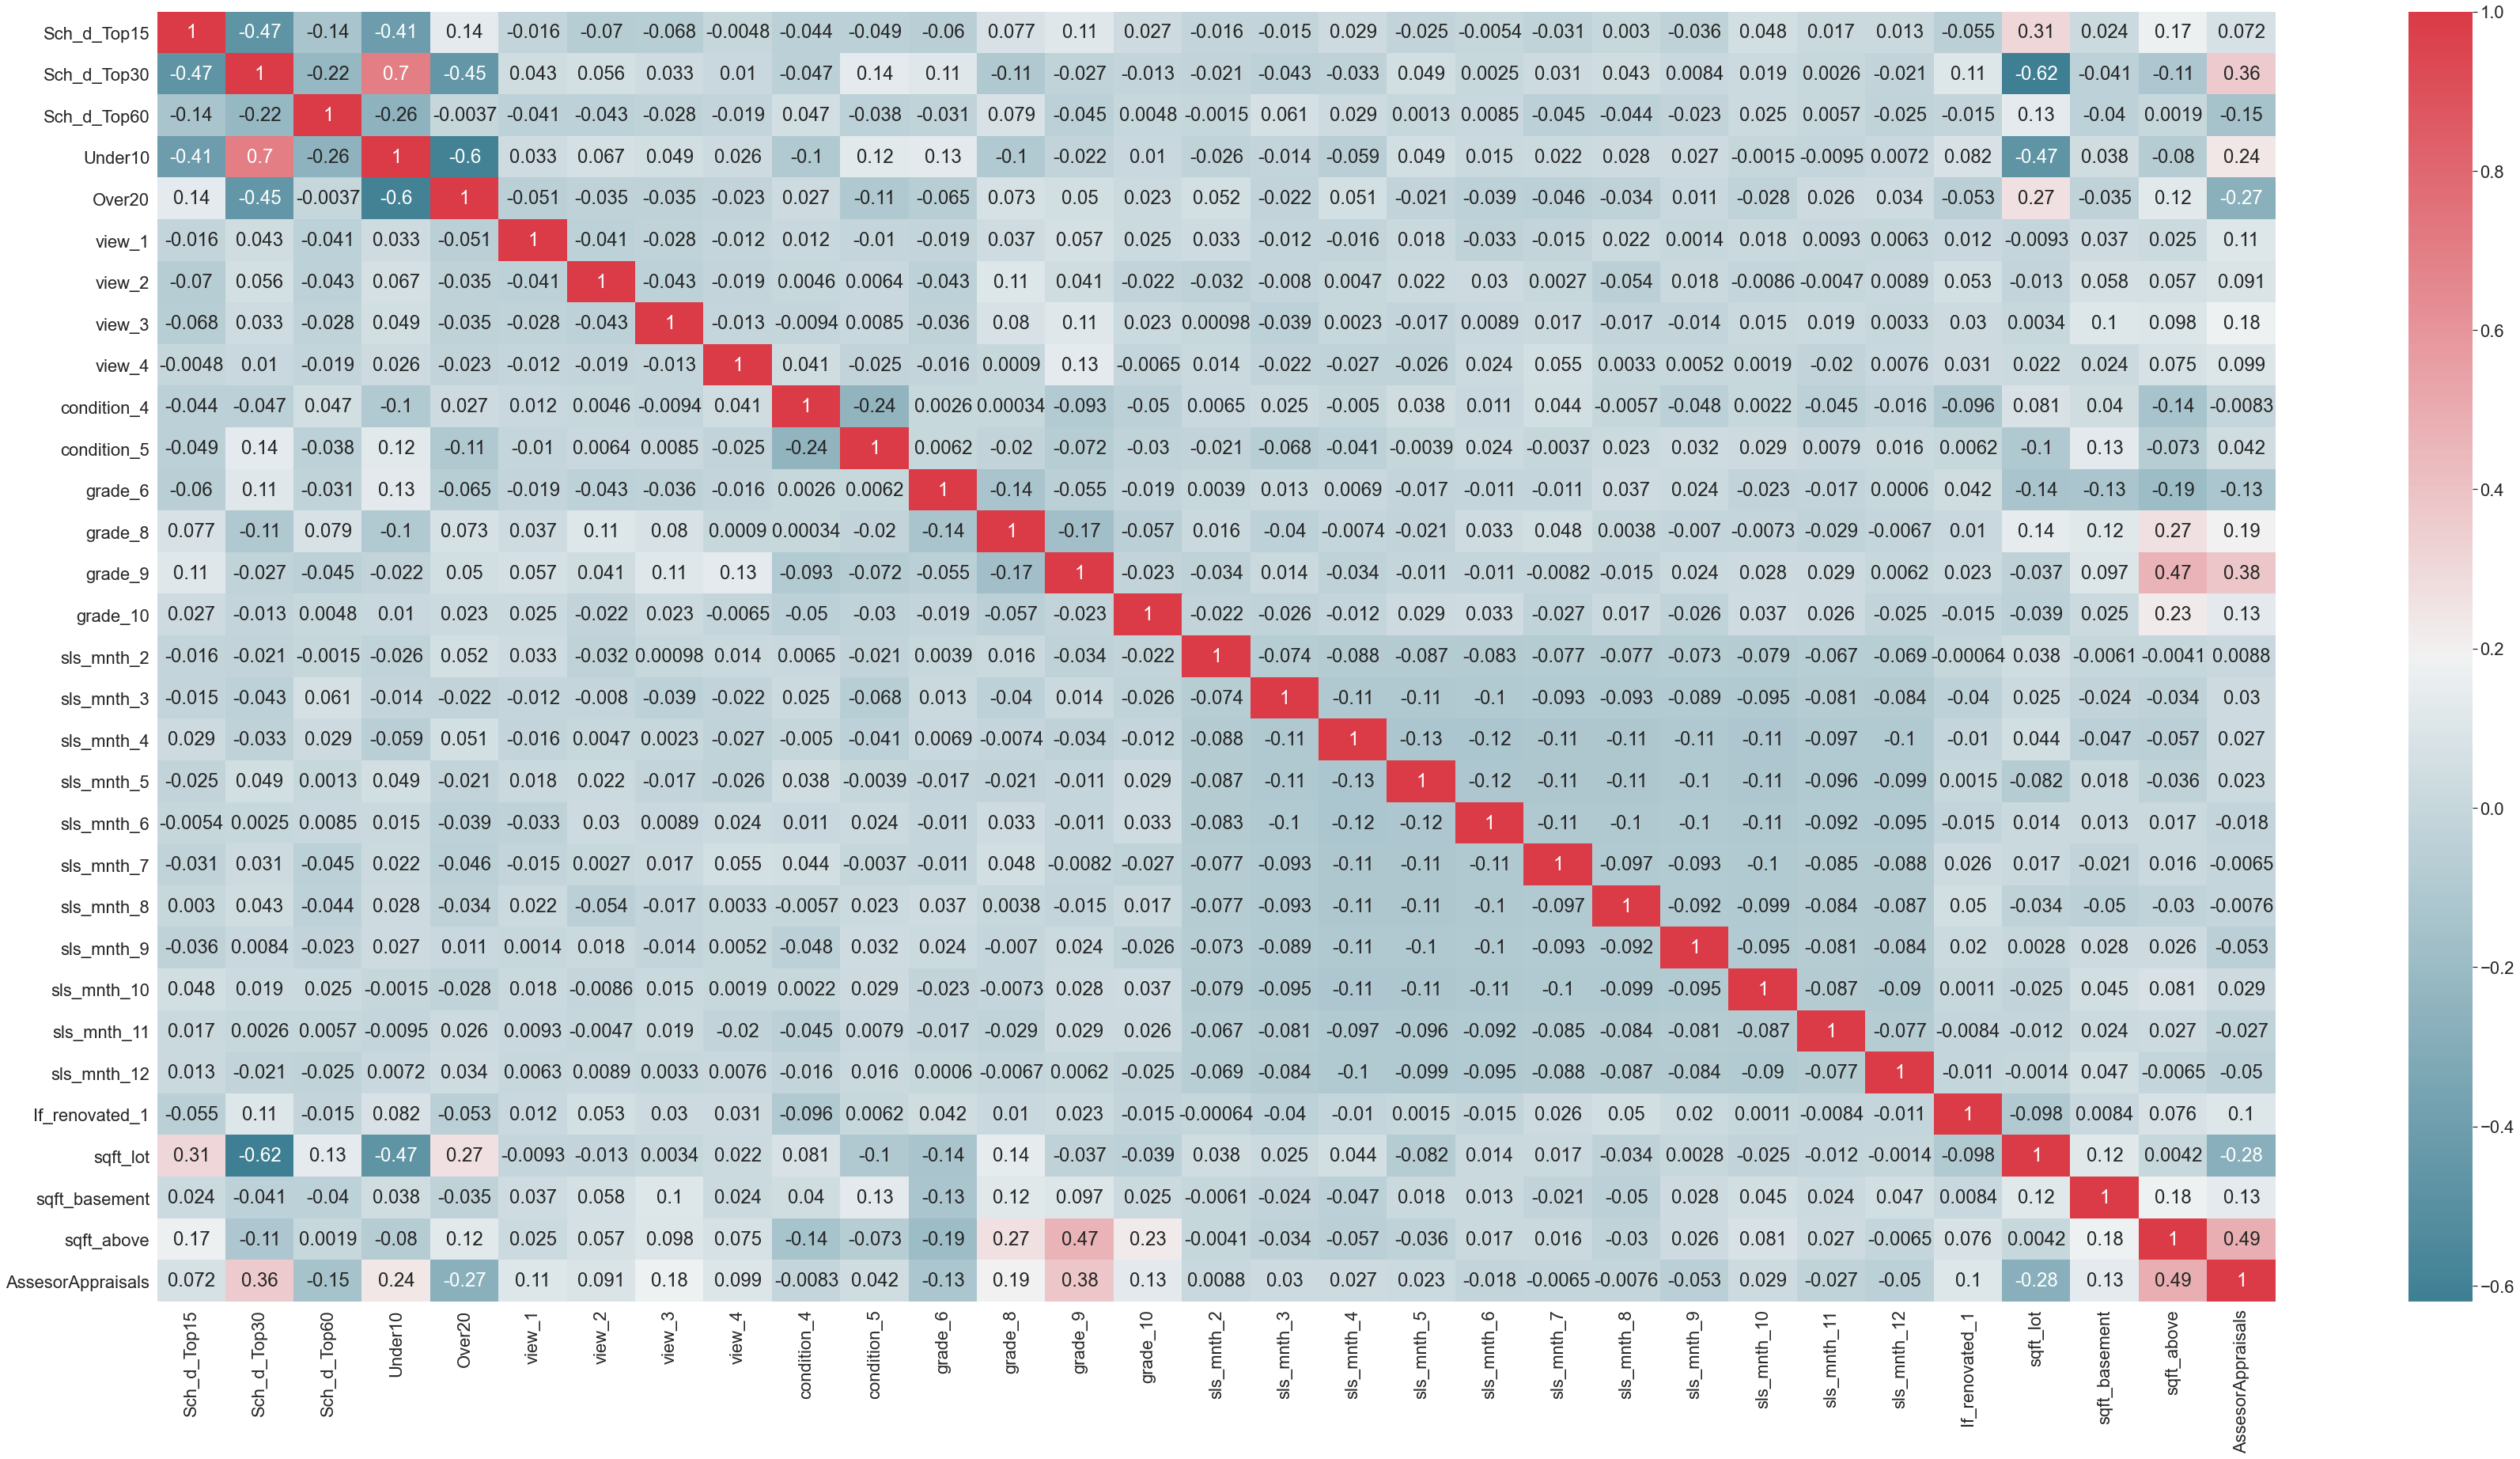

In [184]:
correlation_heatmap(data_Review_Colinearity_Model3)

## C. Create Pickle of Dataset

In [185]:
FieldsMovingForward = ['id','date', 'price', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'log_price']
FieldsMovingForward.extend(data_Review_Colinearity_Model3.columns)
df_data_with_Appraisals = df_data_with_Appraisals[FieldsMovingForward]

In [186]:
import pickle
# Save
with open('regression_Data_Third_Model.pickle', 'wb') as f:
    pickle.dump(df_data_with_Appraisals, f)

In [ ]:
# scaler_

# Ensure linearity of features(independent) to target(dependent)

In [ ]:
data_No_Outliers["price"].describe().apply("${0:,.0f}".format)
#"Average" - middle class houses between 367k& 638$k

In [ ]:
data_pred = data_No_Outliers[['YrRollingAppraisal','AppraisedLandValue', 'AppraisedImpsValue', 'LandToHouseCheck',
       'InflationSinceLastAppraisal','bedrooms', 'bathrooms', 'sqft_living',
                                          'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
                                          'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15','YearsSinceRenovation', 'AgeOfHome', 
                                          'price', 'HotnessScore', 'State Rank','#1Attractions', 
                                          '#2Attractions', '#3Attractions']]

plt.figure(figsize=(60,40), facecolor="white")
sns.set(font_scale=2)

for index, column in enumerate(data_pred):

    if column != "price":
        ax = plt.subplot(6, 5, index+1)
        sns.regplot(x=column, y="price", data=data_No_Outliers, ax=ax, label='medium', line_kws={"color": "red"});
        plt.ticklabel_format(style='plain', axis='both')
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
    
plt.show();
